# Synthetic classification tasks

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tqdm

from pytorchtools import EarlyStopping

import models as m
import torch_utils as tu
from torch_utils import DatasetSpec
import utils as u
import viz as v

In [2]:
tu.set_seed()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

Random seed set as 42


device(type='cuda')

### Load M. buryatense expression data with 300bp upstream regions

In [3]:
data_filename = "data/XY_lr_noCu_opFilt_20221031.tsv"
XYdf = pd.read_csv(data_filename,sep='\t')
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,0.047594,0.823884,-0.215152,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,0.175844,1.069860,-0.135315,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,0.087538,0.940938,-0.153989,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,0.032773,0.520115,-0.260747,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,0.064979,-0.141051,0.073257,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,0.008150,-0.382673,1.440100,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,-0.005709,-0.374488,1.421917,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,0.015365,-0.322437,1.406791,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,-0.183282,0.157790,-0.270536,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502


# 2. Synthetic 6-mer motif classification in 300bp seqs

In [4]:
score_dict = {
    'A':5,
    'C':2,
    'G':-2,
    'T':-5,
    'N':0
}

def score_seq(seq):
    score = np.mean([score_dict[base] for base in seq])
    if 'TATATA' in seq:
        score += 10
    if 'GCGCGC' in seq:
        score -= 10
    return score

XYdf['score'] = XYdf['upstream_region'].apply(lambda x: score_seq(x))
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,score
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,0.823884,-0.215152,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,-0.563333
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,1.069860,-0.135315,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,-0.130000
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,0.940938,-0.153989,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,-0.073333
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.520115,-0.260747,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,0.220000
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,-0.141051,0.073257,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,-0.146667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,-0.382673,1.440100,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,0.383333
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,-0.374488,1.421917,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,0.383333
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,-0.322437,1.406791,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,-0.220000
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,0.157790,-0.270536,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,-0.236667


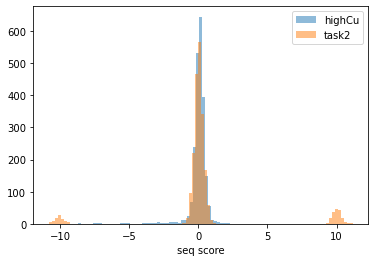

In [5]:
plt.hist(XYdf['highCu'],bins=50,alpha=0.5,label='highCu')
plt.hist(XYdf['score'],bins=100,alpha=0.5,label='task2')
plt.xlabel("seq score")
plt.legend()
plt.show()

In [6]:
tu.set_reg_class_up_down(XYdf,'score',thresh=5)
XYdf['score_reg_UD'].value_counts()

1    1954
2     169
0      88
Name: score_reg_UD, dtype: int64

Minority classes are about 4% or 7% of the total examples

In [7]:
# rename for convenience
XYdf = XYdf.rename(columns={'score_reg_UD':'task2_class'})
XYdf.columns

Index(['og_index', 'locus_tag', 'upstream_region', 'uMax', 'lowO2_fast_growth',
       'lowCH4', 'MeOH', 'NoCu', 'medCu', 'highCu', 'lowCu',
       'highO2_slow_growth', 'NO3_lowO2_slow_growth', 'WithLanthanum',
       'NoLanthanum', 'LanzaTech', 'aa3_KO', 'crotonic_acid', 'CH4_500ppm',
       'CH4_1000ppm', 'score', 'task2_class'],
      dtype='object')

### Train/test splitting
Use StratifiedShuffleSplit to make sure the percent of clases is preserved between train/test splits

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit 

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

Train counts:
1    1563
2     135
0      70
Name: task2_class, dtype: int64
Test counts:
1    391
2     34
0     18
Name: task2_class, dtype: int64


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


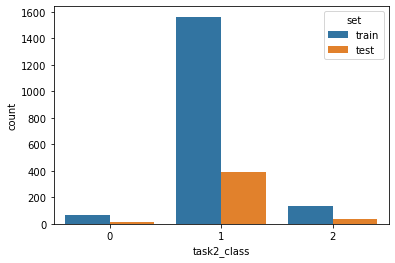

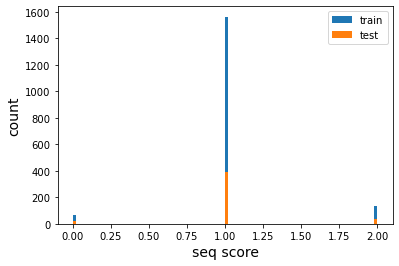

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


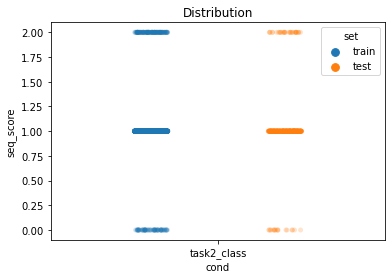

In [9]:
target_col = 'task2_class'
for i, (train_idxs, test_idxs) in enumerate(sss.split(XYdf, XYdf[target_col])):
    train_df = XYdf.iloc[train_idxs]
    test_df = XYdf.iloc[test_idxs]
    
    print(f"Train counts:\n{train_df[target_col].value_counts()}")
    print(f"Test counts:\n{test_df[target_col].value_counts()}")
    
    v.plot_train_test_stacks(train_df, test_df, score_col=target_col)
    v.plot_train_test_hist(train_df, test_df,score_col=target_col,bins=100)
    v.view_train_test_dist(train_df, test_df,[target_col],id_col='locus_tag')




## Load seqs into data loaders

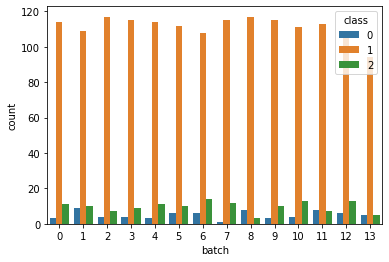

In [10]:
seq_col = 'upstream_region'
target_col = 'task2_class'

dataset_types = [
    DatasetSpec('ohe'),
]

dls = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=None
)


ohe_train_dl,ohe_val_dl = dls['ohe']

v.see_batch_class_dist(ohe_train_dl)

## Run models and collect stats

In [11]:
model_res = {}
pred_dfs = {}
seq_len = len(train_df[seq_col].values[0])

E:179 | train loss:0.156 | val loss: 0.528:   4%|▎         | 179/5000 [00:18<07:06, 11.31it/s]

EarlyStopping counter: 125 out of 500


E:304 | train loss:0.065 | val loss: 0.722:   6%|▌         | 305/5000 [00:29<06:54, 11.32it/s]

EarlyStopping counter: 250 out of 500


E:429 | train loss:0.034 | val loss: 0.918:   9%|▊         | 429/5000 [00:40<06:41, 11.38it/s]

EarlyStopping counter: 375 out of 500


E:552 | train loss:0.023 | val loss: 1.065:  11%|█         | 552/5000 [00:51<06:55, 10.70it/s]


EarlyStopping counter: 500 out of 500
Early stopping


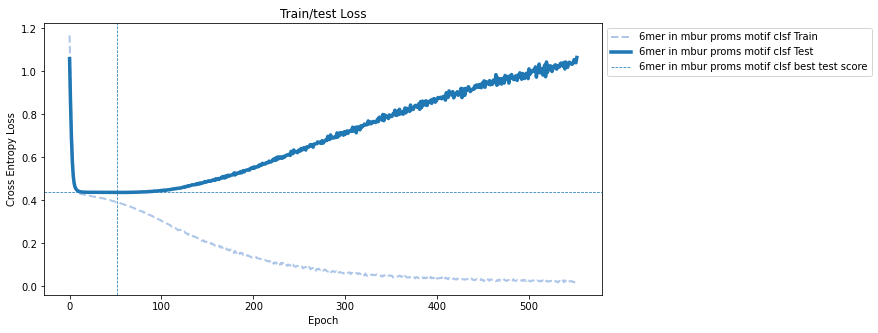

In [12]:
cnn1_name = "6mer in mbur proms motif clsf"
model = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10
)

model_res[cnn1_name] = tu.collect_model_stats(
    cnn1_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model,
    loss_type='classification'
)

Running predictions for 6mer in mbur proms motif clsf


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


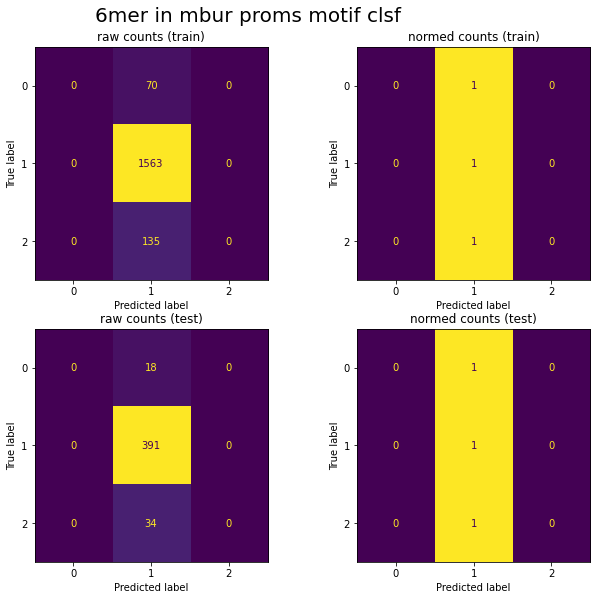

In [13]:
seq_col = 'upstream_region'
target_col = 'task2_class'

seq_list = [
    (train_df[seq_col].values,train_df[target_col],"train"),
    (test_df[seq_col].values,test_df[target_col],"test")
]

pred_dfs[cnn1_name] = tu.get_confusion_stats(
    model_res[cnn1_name]['model'],
    model_res[cnn1_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn1_name]['model_name']}"
)

# Retry with a balanced sampler

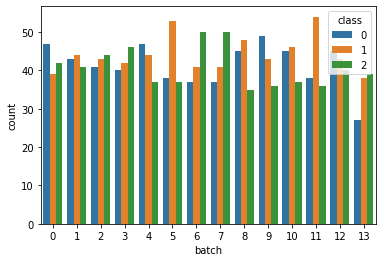

In [14]:
sampler = tu.make_weighted_sampler(train_df,target_col)
dls = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=sampler,
    shuffle=False
)

ohe_train_dl,ohe_val_dl = dls['ohe']

v.see_batch_class_dist(ohe_train_dl)

E:229 | train loss:0.082 | val loss: 0.770:   5%|▍         | 229/5000 [00:20<07:06, 11.18it/s]

EarlyStopping counter: 125 out of 500


E:354 | train loss:0.050 | val loss: 0.892:   7%|▋         | 355/5000 [00:32<06:55, 11.18it/s]

EarlyStopping counter: 250 out of 500


E:479 | train loss:0.040 | val loss: 0.993:  10%|▉         | 479/5000 [00:43<06:44, 11.19it/s]

EarlyStopping counter: 375 out of 500


E:602 | train loss:0.027 | val loss: 1.073:  12%|█▏        | 602/5000 [00:54<06:36, 11.10it/s]


EarlyStopping counter: 500 out of 500
Early stopping


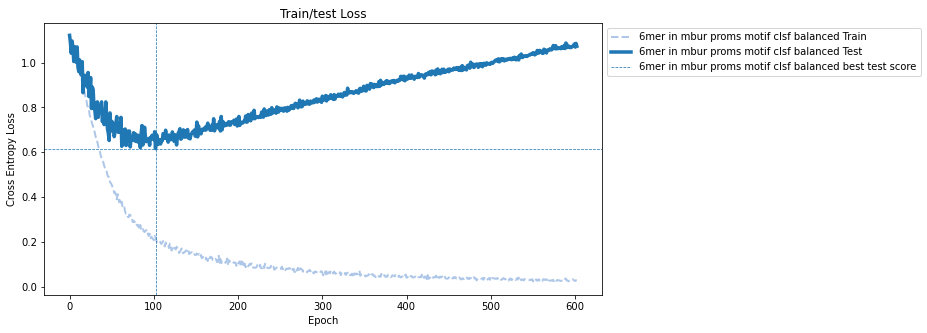

In [15]:
cnn2_name = "6mer in mbur proms motif clsf balanced"
model2 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10
)

model_res[cnn2_name] = tu.collect_model_stats(
    cnn2_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model2,
    loss_type='classification'
)

Running predictions for 6mer in mbur proms motif clsf balanced


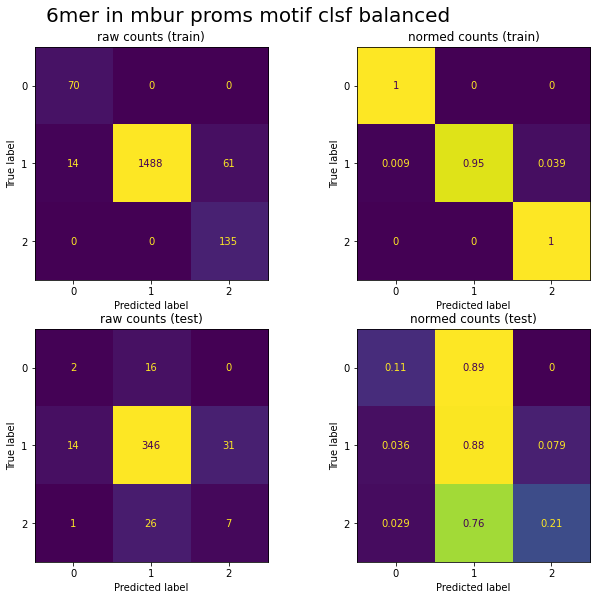

In [16]:
pred_dfs[cnn2_name] = tu.get_confusion_stats(
    model_res[cnn2_name]['model'],
    model_res[cnn2_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn2_name]['model_name']}"
)

Hm, so far, not so good. Even rebalancing the sampler didn't prevent overfitting. Is it better than random though?

# Compare these results to shuffling the inputs sequences
Use the same class assignments for `posc` but shuffle the sequence so that the motif is usually lost

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


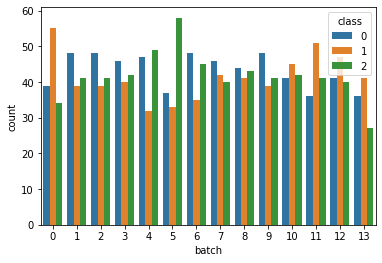

In [17]:
seq_col = 'shuffled_seq'
target_col = 'task2_class'

def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

train_df[seq_col] = train_df['upstream_region'].apply(lambda x: shuffle_seq(x))
test_df[seq_col] = test_df['upstream_region'].apply(lambda x: shuffle_seq(x))

dls_shuff = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=sampler,
    shuffle=False
)


ohe_train_dl_shuff,ohe_val_dl_shuff = dls_shuff['ohe']

v.see_batch_class_dist(ohe_train_dl_shuff)

E:220 | train loss:0.082 | val loss: 0.737:   4%|▍         | 221/5000 [00:19<07:01, 11.35it/s]

EarlyStopping counter: 125 out of 500


E:345 | train loss:0.050 | val loss: 0.891:   7%|▋         | 345/5000 [00:30<06:50, 11.34it/s]

EarlyStopping counter: 250 out of 500


E:470 | train loss:0.030 | val loss: 1.021:   9%|▉         | 471/5000 [00:41<06:35, 11.46it/s]

EarlyStopping counter: 375 out of 500


E:593 | train loss:0.020 | val loss: 1.119:  12%|█▏        | 593/5000 [00:52<06:28, 11.33it/s]


EarlyStopping counter: 500 out of 500
Early stopping


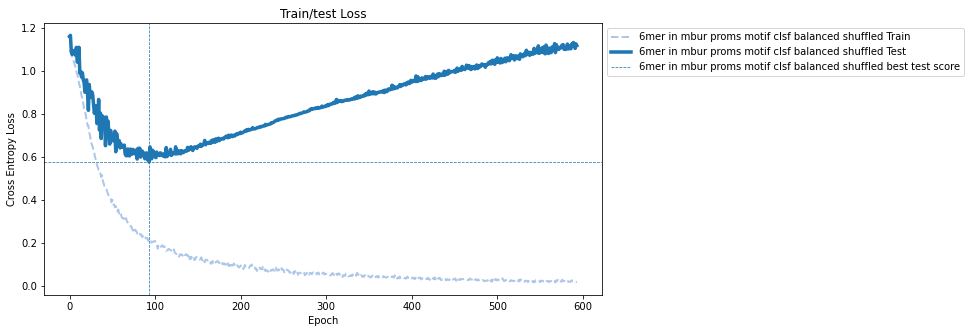

In [18]:
cnn3_name = "6mer in mbur proms motif clsf balanced shuffled"
model3 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10
)

model_res[cnn3_name] = tu.collect_model_stats(
    cnn3_name,
    seq_len,
    ohe_train_dl_shuff,
    ohe_val_dl_shuff,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model3,
    loss_type='classification'
)

Running predictions for 6mer in mbur proms motif clsf balanced shuffled


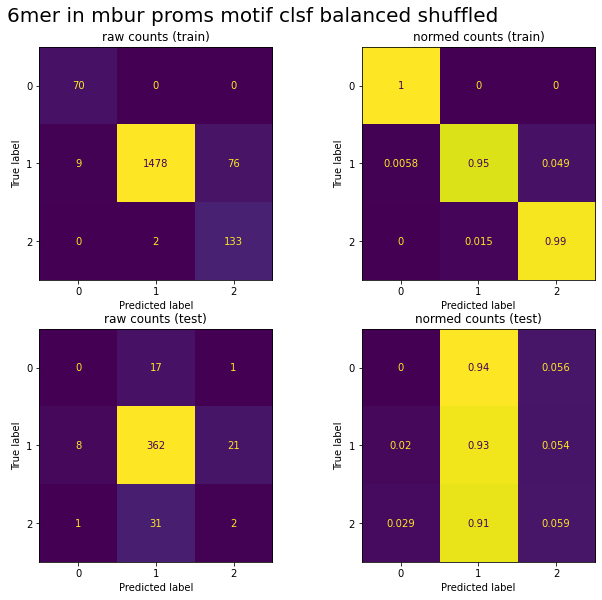

In [19]:
seq_list_shuff = [
    (train_df[seq_col].values,train_df[target_col],"train"),
    (test_df[seq_col].values,test_df[target_col],"test")
]

pred_dfs[cnn3_name] = tu.get_confusion_stats(
    model_res[cnn3_name]['model'],
    model_res[cnn3_name]['model_name'],
    seq_list_shuff,
    DEVICE,
    title=f"{model_res[cnn3_name]['model_name']}"
)

Total convolutional layers: 1
Num filters 8
filt_width 6
Seq 0 of 1768
Seq 100 of 1768
Seq 200 of 1768
Seq 300 of 1768
Seq 400 of 1768
Seq 500 of 1768
Seq 600 of 1768
Seq 700 of 1768
Seq 800 of 1768
Seq 900 of 1768
Seq 1000 of 1768
Seq 1100 of 1768
Seq 1200 of 1768
Seq 1300 of 1768
Seq 1400 of 1768
Seq 1500 of 1768
Seq 1600 of 1768
Seq 1700 of 1768
torch.Size([8, 4, 6])


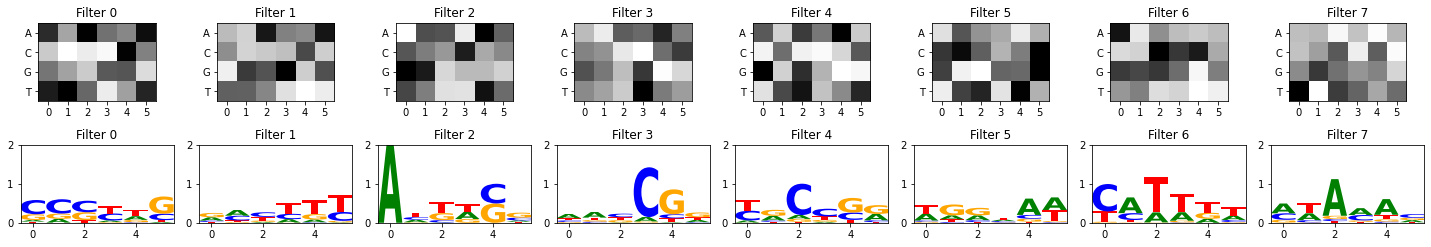

In [20]:
# Check filters of Model 2?
seqs = train_df['upstream_region'].values
v.view_conv2D_wrapper(model2,seqs,DEVICE,act_thresh=1.0,ysc=0.25)

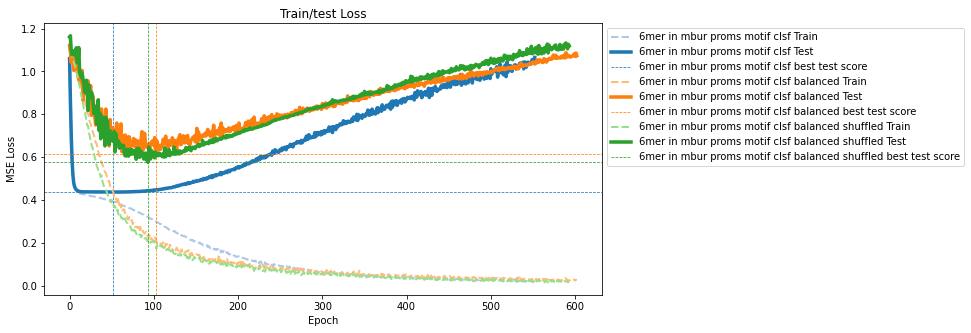

In [21]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [22]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

,model_name,split,mac_precision,mac_recall,mac_f1,support
0,6mer in mbur proms motif clsf,train,0.294683,0.333333,0.312819,1768
1,6mer in mbur proms motif clsf,test,0.294206,0.333333,0.312550,443
0,6mer in mbur proms motif clsf balanced,train,0.840703,0.984005,0.900073,1768
1,6mer in mbur proms motif clsf balanced,test,0.397870,0.400635,0.399016,443
0,6mer in mbur proms motif clsf balanced shuffled,train,0.840363,0.976934,0.894754,1768
1,6mer in mbur proms motif clsf balanced shuffled,test,0.322087,0.328218,0.324279,443


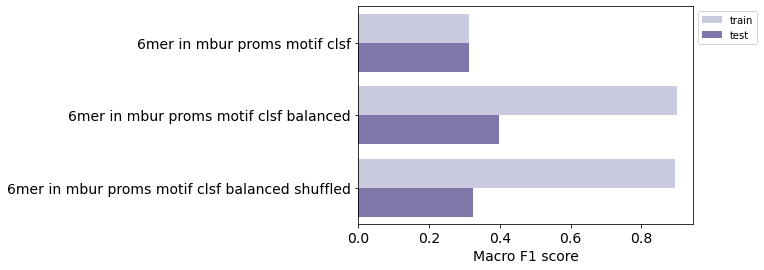

In [23]:
sns.barplot(data=all_preds,y='model_name',x='mac_f1',hue='split',dodge=True,palette='Purples')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()

In this synthetic example, the models are overfitting to the training data and seemingly unable to generalize to the test data. Maybe in this case, the signal-noise is too hard to overcome with only these sequences?

To test this, instead of starting with actual M. buryatense sequences, let's randomly generate a bunch!

## Use more randomly generated sequences

In [24]:
seq_length = 300
syn_seqs = []

with tqdm.trange(10000) as pbar:
    for i in pbar:
        if i%1000 == 0:
            pbar.set_description(f"i:{i}")
        my_seq = ''.join(np.random.choice(('C','G','T','A'), seq_length ))
        syn_seqs.append((i,my_seq))

syn_df = pd.DataFrame(syn_seqs,columns=['id','seq'])
syn_df.head()


i:9000: 100%|██████████| 10000/10000 [00:00<00:00, 10678.65it/s]


,id,seq
0,0,CAACTGTCTATCATTAGAGCCAACGCACAACGTCTCTGGCATAAAG...
1,1,GATTCTCTGCCGCTTCTACGACGTGATCTCCGGGAAGATTAATCTT...
2,2,GTTCCTGCTTAGAGCGTTGGGAGCAAGCATAGCGTTTGAGCATGTT...
3,3,AGCACTCCGCAATAGTAGAACAAGGCACATTCCCGGGCATCGGCCG...
4,4,CTTCTAAGGCGACCGACAAAGTTCAGAAGTAATGCTCCTACCGACG...


In [25]:
syn_df['score'] = syn_df['seq'].apply(lambda x: score_seq(x))
syn_df

,id,seq,score
0,0,CAACTGTCTATCATTAGAGCCAACGCACAACGTCTCTGGCATAAAG...,0.310000
1,1,GATTCTCTGCCGCTTCTACGACGTGATCTCCGGGAAGATTAATCTT...,-0.080000
2,2,GTTCCTGCTTAGAGCGTTGGGAGCAAGCATAGCGTTTGAGCATGTT...,-0.040000
3,3,AGCACTCCGCAATAGTAGAACAAGGCACATTCCCGGGCATCGGCCG...,0.260000
4,4,CTTCTAAGGCGACCGACAAAGTTCAGAAGTAATGCTCCTACCGACG...,0.040000
...,...,...,...
9995,9995,TGCATCGAGATCGTAAAAAGGTAATCATCGCCGCCGGCCATAAATT...,0.166667
9996,9996,ACAGGGTCGTCGAACACCCCAGGATGATGCCGAATTCGGCAAGGGC...,10.246667
9997,9997,AGGGCTTCACGAATCTGCGAGTGAATCCCTTTATCCAGGGTGAGCG...,-0.013333
9998,9998,CGACATAGGCGGTTATGCATCTGGGAGCCGTGGCGCAACTCTGGTT...,-0.353333


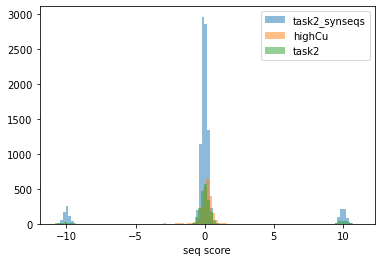

In [26]:
plt.hist(syn_df['score'],bins=100,alpha=0.5,label='task2_synseqs')
plt.hist(XYdf['highCu'],bins=50,alpha=0.5,label='highCu')
plt.hist(XYdf['score'],bins=100,alpha=0.5,label='task2')
plt.xlabel("seq score")
plt.legend()
plt.show()

In [27]:
tu.set_reg_class_up_down(syn_df,'score',thresh=5)
syn_df['score_reg_UD'].value_counts()

1    8741
2     631
0     628
Name: score_reg_UD, dtype: int64

Each minority class is about 6% of the total inputs

In [28]:
# rename for convenience
syn_df = syn_df.rename(columns={'score_reg_UD':'task2_class'})
syn_df.columns

Index(['id', 'seq', 'score', 'task2_class'], dtype='object')

Train counts:
1    6993
2     505
0     502
Name: task2_class, dtype: int64
Test counts:
1    1748
0     126
2     126
Name: task2_class, dtype: int64


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


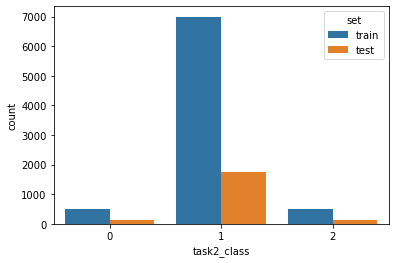

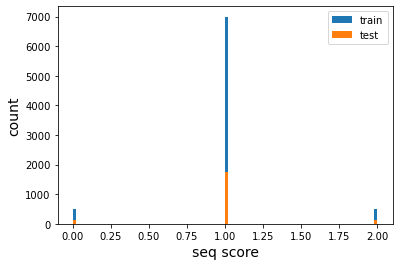

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


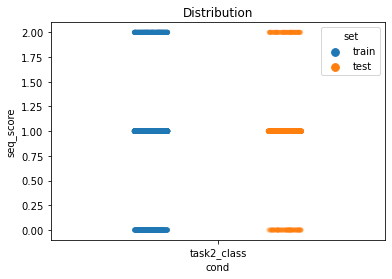

In [29]:
target_col = 'task2_class'
for i, (train_idxs, test_idxs) in enumerate(sss.split(syn_df, syn_df[target_col])):
    syn_train_df = syn_df.iloc[train_idxs]
    syn_test_df = syn_df.iloc[test_idxs]
    
    print(f"Train counts:\n{syn_train_df[target_col].value_counts()}")
    print(f"Test counts:\n{syn_test_df[target_col].value_counts()}")
    
    v.plot_train_test_stacks(syn_train_df, syn_test_df, score_col=target_col)
    v.plot_train_test_hist(syn_train_df, syn_test_df,score_col=target_col,bins=100)
    v.view_train_test_dist(syn_train_df, syn_test_df,[target_col],id_col='id')


## Load seqs into data loaders

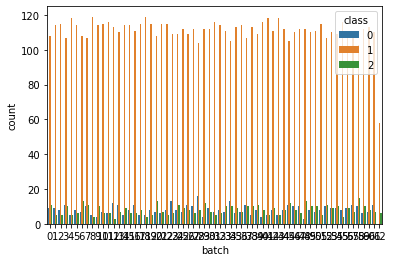

In [30]:
seq_col = 'seq'
target_col = 'task2_class'

dataset_types = [
    DatasetSpec('ohe'),
]

syn_dls = tu.build_dataloaders(
    syn_train_df, 
    syn_test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=None
)


syn_ohe_train_dl,syn_ohe_val_dl = syn_dls['ohe']

v.see_batch_class_dist(syn_ohe_train_dl)

E:173 | train loss:0.352 | val loss: 0.520:   3%|▎         | 174/5000 [01:08<31:26,  2.56it/s]

EarlyStopping counter: 125 out of 500


E:298 | train loss:0.296 | val loss: 0.589:   6%|▌         | 299/5000 [01:58<31:31,  2.49it/s]

EarlyStopping counter: 250 out of 500


E:423 | train loss:0.260 | val loss: 0.644:   8%|▊         | 424/5000 [02:48<30:32,  2.50it/s]

EarlyStopping counter: 375 out of 500


E:548 | train loss:0.235 | val loss: 0.694:  11%|█         | 548/5000 [03:38<29:38,  2.50it/s]

EarlyStopping counter: 500 out of 500
Early stopping


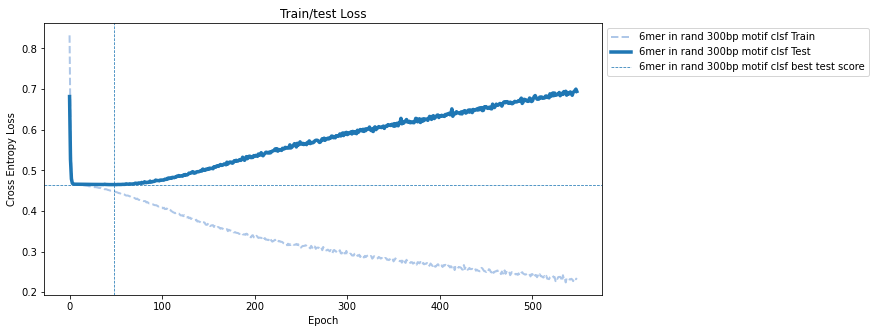

In [31]:
cnn5_name = "6mer in rand 300bp motif clsf"
model5 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10
)

seq_len=len(syn_train_df[seq_col].values[0])

model_res[cnn5_name] = tu.collect_model_stats(
    cnn5_name,
    seq_len,
    syn_ohe_train_dl,
    syn_ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model5,
    loss_type='classification'
)

Running predictions for 6mer in rand 300bp motif clsf


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


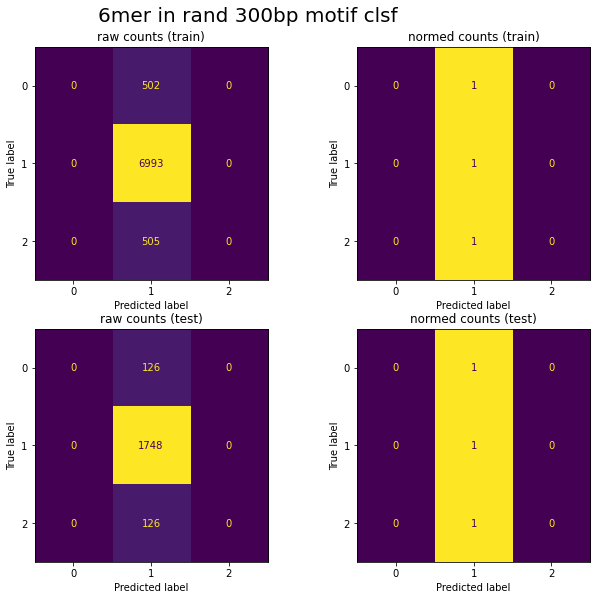

In [32]:
syn_seq_list = [
    (syn_train_df[seq_col].values,syn_train_df[target_col],"train"),
    (syn_test_df[seq_col].values,syn_test_df[target_col],"test")
]

pred_dfs[cnn5_name] = tu.get_confusion_stats(
    model_res[cnn5_name]['model'],
    model_res[cnn5_name]['model_name'],
    syn_seq_list,
    DEVICE,
    title=f"{model_res[cnn5_name]['model_name']}"
)

# Retry with a balanced sampler

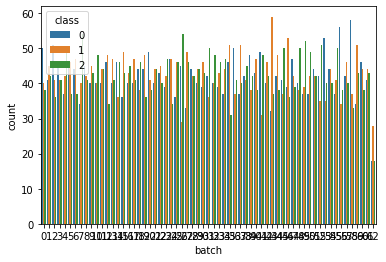

In [33]:
sampler = tu.make_weighted_sampler(syn_train_df,target_col)
syn_dls = tu.build_dataloaders(
    syn_train_df, 
    syn_test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=sampler,
    shuffle=False
)

syn_ohe_train_dl,syn_ohe_val_dl = syn_dls['ohe']

v.see_batch_class_dist(syn_ohe_train_dl)

E:157 | train loss:0.471 | val loss: 0.968:   3%|▎         | 158/5000 [01:04<32:40,  2.47it/s]

EarlyStopping counter: 125 out of 500


E:282 | train loss:0.360 | val loss: 0.966:   6%|▌         | 283/5000 [01:55<32:39,  2.41it/s]

EarlyStopping counter: 250 out of 500


E:407 | train loss:0.265 | val loss: 1.008:   8%|▊         | 408/5000 [02:46<31:57,  2.40it/s]

EarlyStopping counter: 375 out of 500


E:532 | train loss:0.193 | val loss: 1.079:  11%|█         | 532/5000 [03:36<30:19,  2.46it/s]

EarlyStopping counter: 500 out of 500
Early stopping


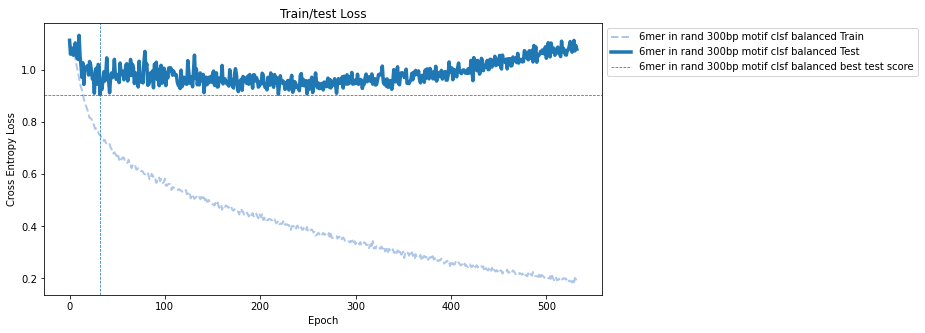

Running predictions for 6mer in rand 300bp motif clsf balanced


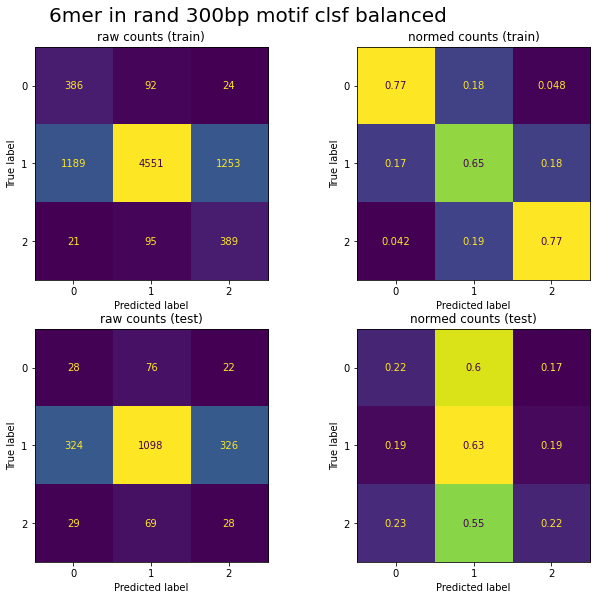

In [34]:
cnn6_name = "6mer in rand 300bp motif clsf balanced"
model6 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10
)

model_res[cnn6_name] = tu.collect_model_stats(
    cnn6_name,
    seq_len,
    syn_ohe_train_dl,
    syn_ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model6,
    loss_type='classification'
)

pred_dfs[cnn6_name] = tu.get_confusion_stats(
    model_res[cnn6_name]['model'],
    model_res[cnn6_name]['model_name'],
    syn_seq_list,
    DEVICE,
    title=f"{model_res[cnn6_name]['model_name']}"
)

Hm, still not getting there. Maybe we need a more complex model?

E:1424 | train loss:0.080 | val loss: 0.051:  28%|██▊       | 1425/5000 [11:59<30:37,  1.95it/s]

EarlyStopping counter: 125 out of 500


E:1836 | train loss:0.063 | val loss: 0.042:  37%|███▋      | 1837/5000 [15:29<26:55,  1.96it/s]

EarlyStopping counter: 125 out of 500


E:1976 | train loss:0.063 | val loss: 0.040:  40%|███▉      | 1977/5000 [16:40<25:30,  1.98it/s]

EarlyStopping counter: 125 out of 500


E:2235 | train loss:0.066 | val loss: 0.037:  45%|████▍     | 2236/5000 [18:55<24:07,  1.91it/s]

EarlyStopping counter: 125 out of 500


E:2575 | train loss:0.063 | val loss: 0.037:  52%|█████▏    | 2576/5000 [21:51<20:40,  1.95it/s]

EarlyStopping counter: 125 out of 500


E:2784 | train loss:0.056 | val loss: 0.035:  56%|█████▌    | 2785/5000 [23:39<19:11,  1.92it/s]

EarlyStopping counter: 125 out of 500


E:2956 | train loss:0.063 | val loss: 0.038:  59%|█████▉    | 2957/5000 [25:08<17:38,  1.93it/s]

EarlyStopping counter: 125 out of 500


E:3081 | train loss:0.056 | val loss: 0.034:  62%|██████▏   | 3082/5000 [26:12<16:25,  1.95it/s]

EarlyStopping counter: 250 out of 500


E:3206 | train loss:0.054 | val loss: 0.034:  64%|██████▍   | 3207/5000 [27:17<15:19,  1.95it/s]

EarlyStopping counter: 375 out of 500


E:3331 | train loss:0.048 | val loss: 0.039:  67%|██████▋   | 3331/5000 [28:22<14:12,  1.96it/s]

EarlyStopping counter: 500 out of 500
Early stopping


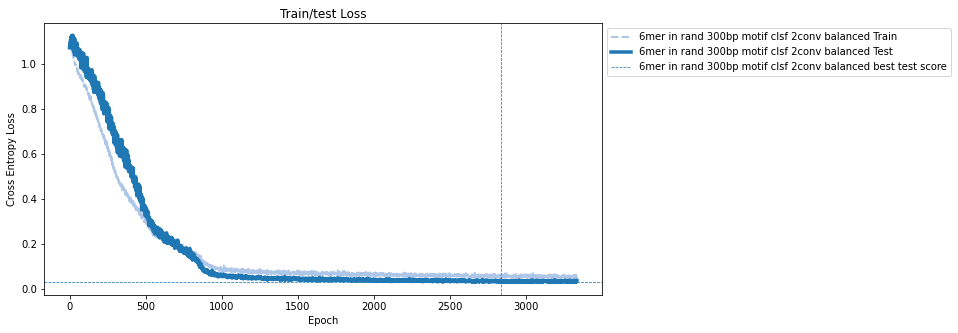

Running predictions for 6mer in rand 300bp motif clsf 2conv balanced


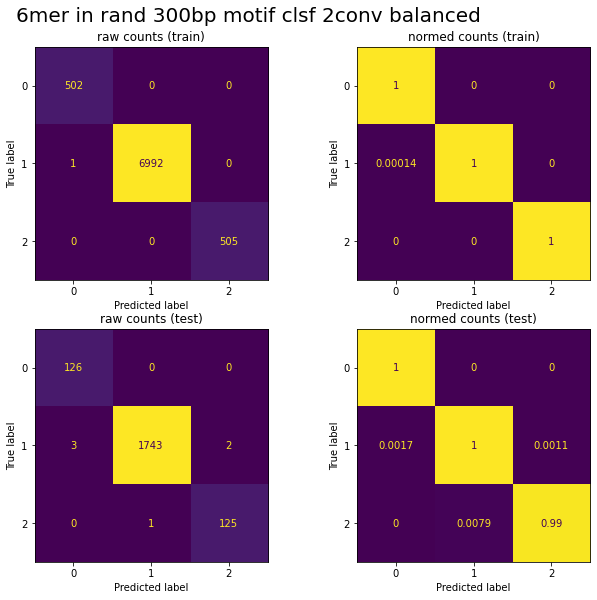

In [35]:
cnn7_name = "6mer in rand 300bp motif clsf 2conv balanced"

model7 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=3,
    num_filters1=8,
    num_filters2=8,
    kernel_size1=6,
    kernel_size2=6,
    conv_pool_size1=3,
    fc_node_num1=10,
    fc_node_num2=10,
)

model_res[cnn7_name] = tu.collect_model_stats(
    cnn7_name,
    seq_len,
    syn_ohe_train_dl,
    syn_ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model7,
    loss_type='classification'
)

pred_dfs[cnn7_name] = tu.get_confusion_stats(
    model_res[cnn7_name]['model'],
    model_res[cnn7_name]['model_name'],
    syn_seq_list,
    DEVICE,
    title=f"{model_res[cnn7_name]['model_name']}"
)

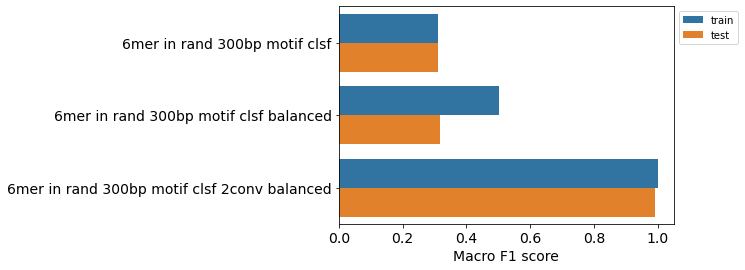

In [36]:
syn_preds = pd.concat([pred_dfs[x] for x in pred_dfs if 'rand' in x])
syn_preds

sns.barplot(data=syn_preds,y='model_name',x='mac_f1',hue='split',dodge=True)
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()

Ok so this pretty much worked! It's not perfect but the Mac F1 is actually quite good!

Total convolutional layers: 2
Num filters 8
filt_width 6
Seq 0 of 8000
Seq 100 of 8000
Seq 200 of 8000
Seq 300 of 8000
Seq 400 of 8000
Seq 500 of 8000
Seq 600 of 8000
Seq 700 of 8000
Seq 800 of 8000
Seq 900 of 8000
Seq 1000 of 8000
Seq 1100 of 8000
Seq 1200 of 8000
Seq 1300 of 8000
Seq 1400 of 8000
Seq 1500 of 8000
Seq 1600 of 8000
Seq 1700 of 8000
Seq 1800 of 8000
Seq 1900 of 8000
Seq 2000 of 8000
Seq 2100 of 8000
Seq 2200 of 8000
Seq 2300 of 8000
Seq 2400 of 8000
Seq 2500 of 8000
Seq 2600 of 8000
Seq 2700 of 8000
Seq 2800 of 8000
Seq 2900 of 8000
Seq 3000 of 8000
Seq 3100 of 8000
Seq 3200 of 8000
Seq 3300 of 8000
Seq 3400 of 8000
Seq 3500 of 8000
Seq 3600 of 8000
Seq 3700 of 8000
Seq 3800 of 8000
Seq 3900 of 8000
Seq 4000 of 8000
Seq 4100 of 8000
Seq 4200 of 8000
Seq 4300 of 8000
Seq 4400 of 8000
Seq 4500 of 8000
Seq 4600 of 8000
Seq 4700 of 8000
Seq 4800 of 8000
Seq 4900 of 8000
Seq 5000 of 8000
Seq 5100 of 8000
Seq 5200 of 8000
Seq 5300 of 8000
Seq 5400 of 8000
Seq 5500 of 8000
Seq

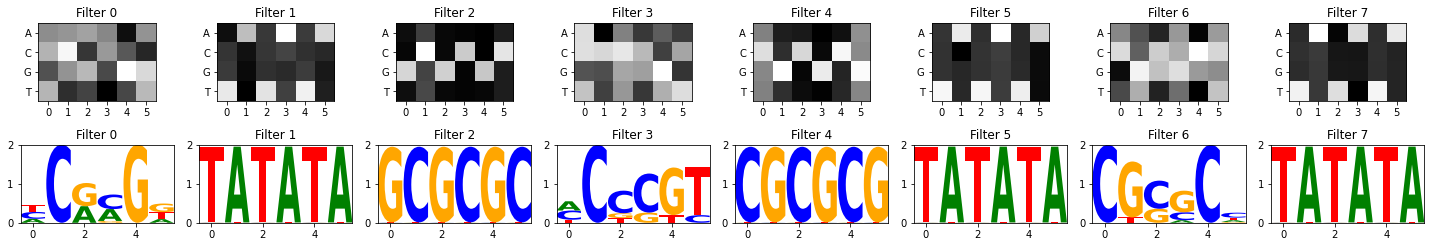

In [37]:
# Check filters of Model 7
seqs = syn_train_df['seq'].values
v.view_conv2D_wrapper(model7,seqs,DEVICE,act_thresh=0.5,ysc=0.25)

Was it just that we needed a more complex model for a more complex task?

Let's retry with the original M bur sequences and the 2 layer model

E:981 | train loss:0.163 | val loss: 0.683:  20%|█▉        | 982/5000 [01:52<07:47,  8.60it/s]

EarlyStopping counter: 125 out of 500


E:1106 | train loss:0.114 | val loss: 0.712:  22%|██▏       | 1107/5000 [02:06<07:31,  8.62it/s]

EarlyStopping counter: 250 out of 500


E:1231 | train loss:0.127 | val loss: 0.744:  25%|██▍       | 1232/5000 [02:20<07:05,  8.85it/s]

EarlyStopping counter: 375 out of 500


E:1355 | train loss:0.111 | val loss: 0.763:  27%|██▋       | 1355/5000 [02:35<06:57,  8.73it/s]


EarlyStopping counter: 500 out of 500
Early stopping


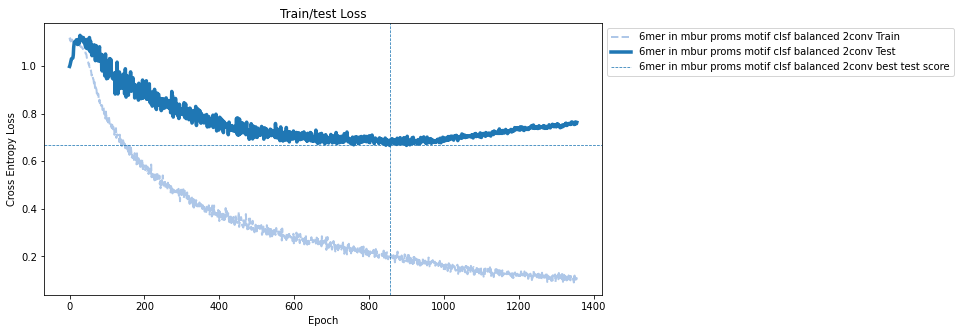

Running predictions for 6mer in mbur proms motif clsf balanced 2conv


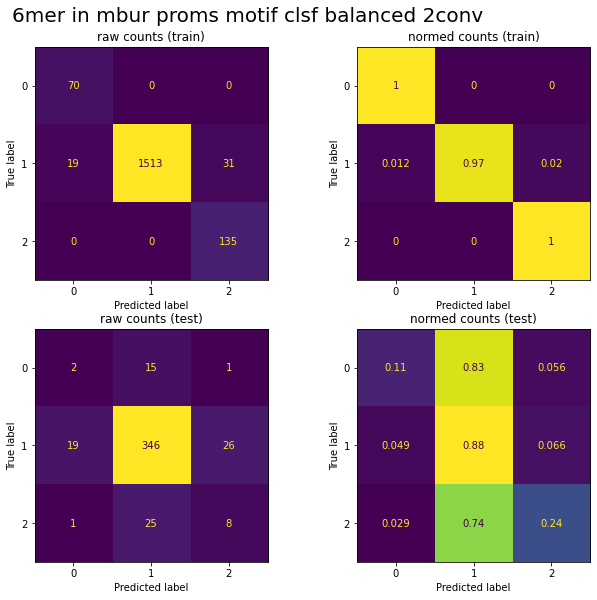

In [38]:
model8 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=3,
    num_filters1=8,
    num_filters2=8,
    kernel_size1=6,
    kernel_size2=6,
    conv_pool_size1=3,
    fc_node_num1=10,
    fc_node_num2=10,
)

cnn8_name = "6mer in mbur proms motif clsf balanced 2conv"

model_res[cnn8_name] = tu.collect_model_stats(
    cnn8_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model8,
    loss_type='classification'
)

pred_dfs[cnn8_name] = tu.get_confusion_stats(
    model_res[cnn8_name]['model'],
    model_res[cnn8_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn8_name]['model_name']}"
)

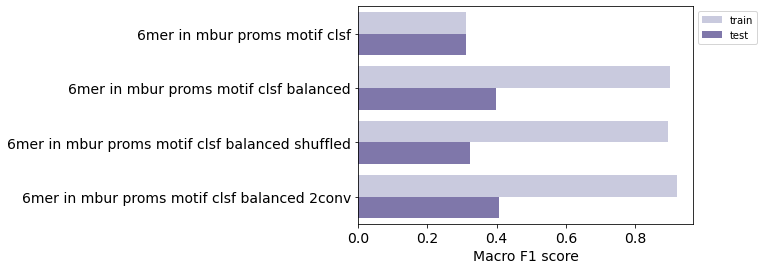

In [39]:
mbur_preds = pd.concat([pred_dfs[x] for x in pred_dfs if 'mbur' in x])
mbur_preds

sns.barplot(data=mbur_preds,y='model_name',x='mac_f1',hue='split',dodge=True,palette='Purples')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()


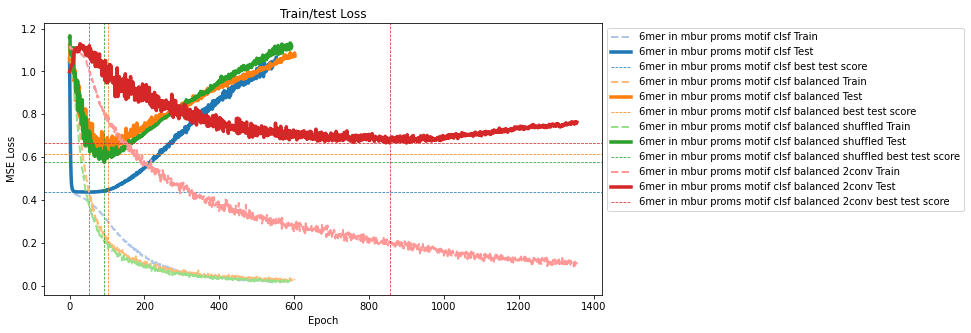

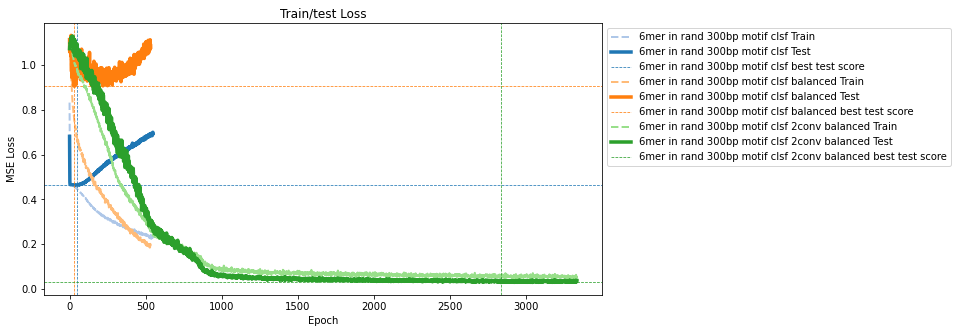

In [40]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res if 'mbur' in x])
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res if 'rand' in x])

The 2conv layers seemed to help a little on the M. buryatense sequences, but didn't do quite as well as the 10K random sequences.

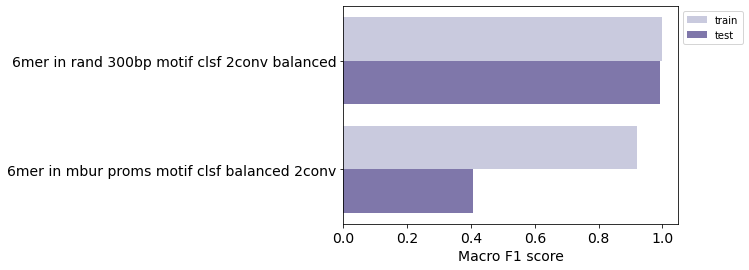

In [43]:
conv2_preds = pd.concat([pred_dfs[x] for x in pred_dfs if '2conv' in x])
conv2_preds

sns.barplot(data=conv2_preds,y='model_name',x='mac_f1',hue='split',dodge=True,palette='Purples')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()


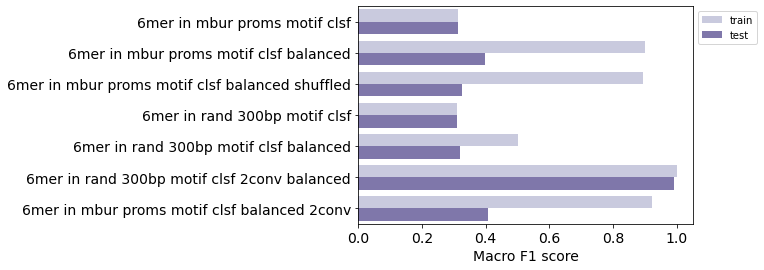

In [44]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

sns.barplot(data=all_preds,y='model_name',x='mac_f1',hue='split',dodge=True,palette='Purples')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()

It seems like there's a few different dimensions to play with here:
* How many total sequences are there? (affects total training examples)
* How long are the sequences? (affects the signal to noise ratio of the 6-mer)
* How complex is the model?


# Summary of model performances across different dataset sizes, sequence lengths, and model architectures.

Varied:
* Model arch: Simple CNN, 2Conv CNN, 2Conv CNN with Pooling
* Number of training seqs: 2K, 6K, 10K
* Length of sequence: 50bp, 150bp, 300bp
* Ran 5 folds for each level

After running a number of combinations of each of these levers in `synth_classification_randomseqs.py`, and collecting the results in `out_synth_cls/synth_cls_result_df.tsv`, here are some summary plots.

In [3]:
df = pd.read_csv('out_synth_cls/synth_cls_result_df.tsv',sep='\t')
df

,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,ds_size,seq_len,fold,best_val_score,epoch_stop,total_time
0,CNN_simple_fold1_300bp_10000seqs,train,0.645383,0.942404,0.724316,8000,CNN_simple,10000,300,1,0.904715,173,136.595901
1,CNN_simple_fold1_300bp_10000seqs,test,0.328935,0.325420,0.317209,2000,CNN_simple,10000,300,1,0.904715,173,136.595901
2,2CNN_fold2_50bp_10000seqs,train,0.984674,0.999830,0.992072,8000,2CNN,10000,50,2,0.033585,1389,420.815815
3,2CNN_fold2_50bp_10000seqs,test,0.933013,0.916613,0.924589,2000,2CNN,10000,50,2,0.033585,1389,420.815815
4,CNN_simple_fold3_300bp_10000seqs,train,0.498562,0.774438,0.530756,8000,CNN_simple,10000,300,3,0.948965,45,114.912976
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2CNN_pool_fold1_50bp_2000seqs,test,0.437676,0.395737,0.411146,400,2CNN_pool,2000,50,1,0.179892,1662,99.021336
266,CNN_simple_fold2_50bp_2000seqs,train,0.718008,0.994679,0.817854,1600,CNN_simple,2000,50,2,0.255622,349,31.229858
267,CNN_simple_fold2_50bp_2000seqs,test,0.325459,0.317136,0.321244,400,CNN_simple,2000,50,2,0.255622,349,31.229858
268,2CNN_fold2_150bp_10000seqs,train,1.000000,1.000000,1.000000,8000,2CNN,10000,150,2,0.150642,4510,1265.730436


In [4]:
df_test = df[df['split']=='test']

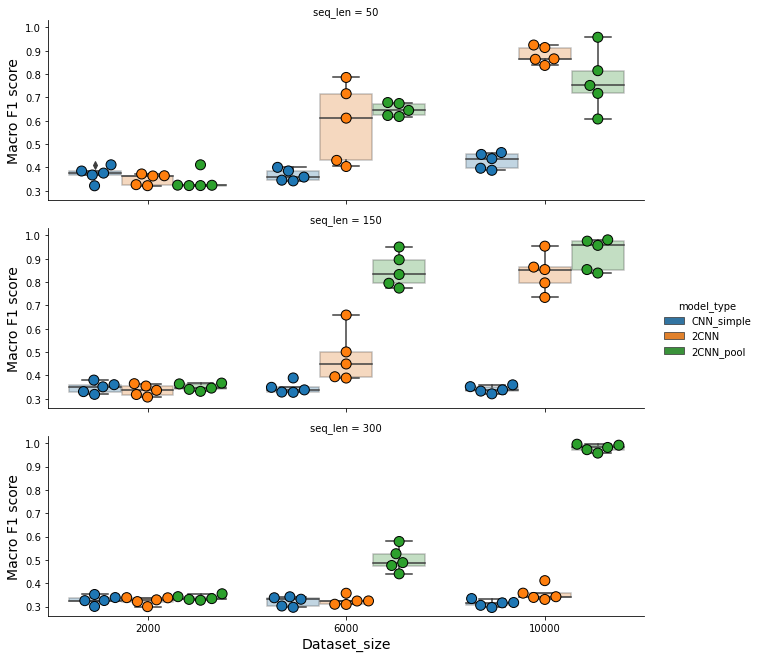

In [5]:
order = ['CNN_simple','2CNN','2CNN_pool']

g = sns.catplot(
    data=df_test, x='ds_size', y='mac_f1',
    row='seq_len', kind='box',hue='model_type',
    hue_order=order,
    boxprops=dict(alpha=.3),height=3,aspect=6/2
)
g.map_dataframe(sns.swarmplot, x='ds_size', y='mac_f1',
                hue='model_type',size=10, 
                hue_order=order,
                edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Dataset_size",fontsize=14)

plt.show()



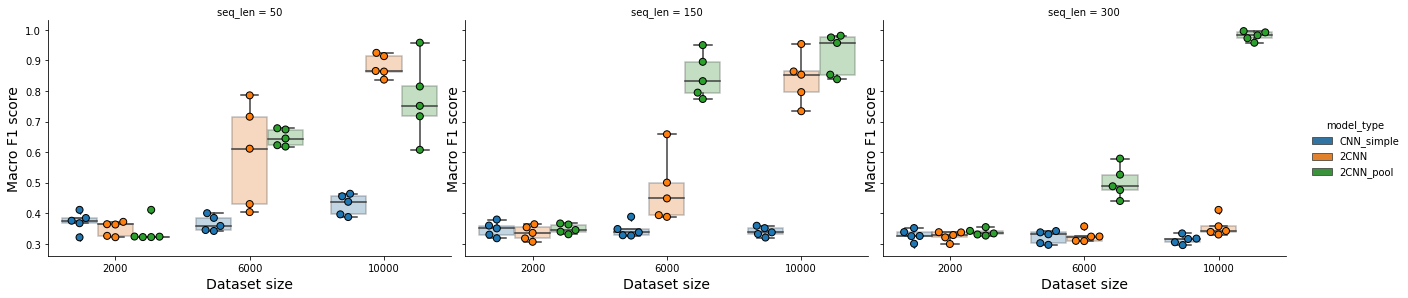

In [6]:
order = ['CNN_simple','2CNN','2CNN_pool']

g = sns.catplot(
    data=df_test, x='ds_size', y='mac_f1',
    col='seq_len', kind='box',hue='model_type',
    hue_order=order,
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='ds_size', y='mac_f1',
                hue='model_type',size=7, 
                hue_order=order,
                edgecolor='black',linewidth=1, dodge=True,palette='tab10')
for ax in g.axes.flatten():
    ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.show()



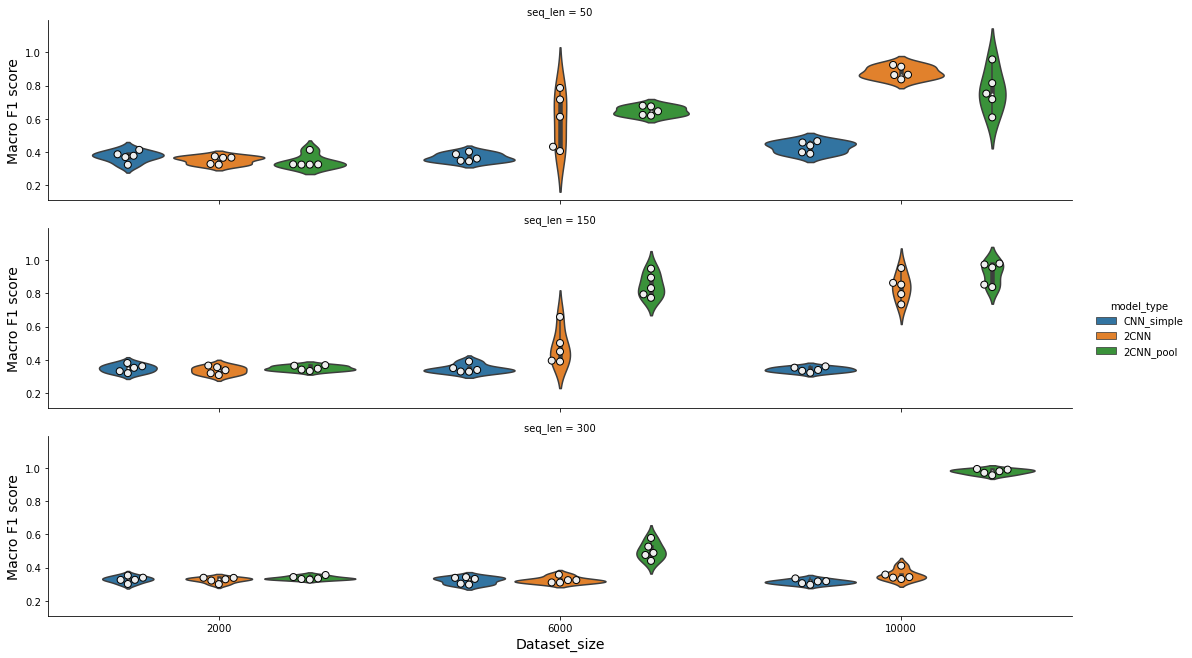

In [48]:
order = ['CNN_simple','2CNN','2CNN_pool']

g = sns.catplot(
    data=df_test, x='ds_size', y='mac_f1',
    row='seq_len', kind='violin',hue='model_type',
    hue_order=order,
    alpha=.3,height=3,aspect=10/2
)

g.map_dataframe(sns.swarmplot, x='ds_size', y='mac_f1',
                hue='model_type',size=7, 
                hue_order=order,
                edgecolor='black',linewidth=1, dodge=True,palette=['#eeee'])

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Dataset_size",fontsize=14)
#plt.ylim(0,1)
plt.show()



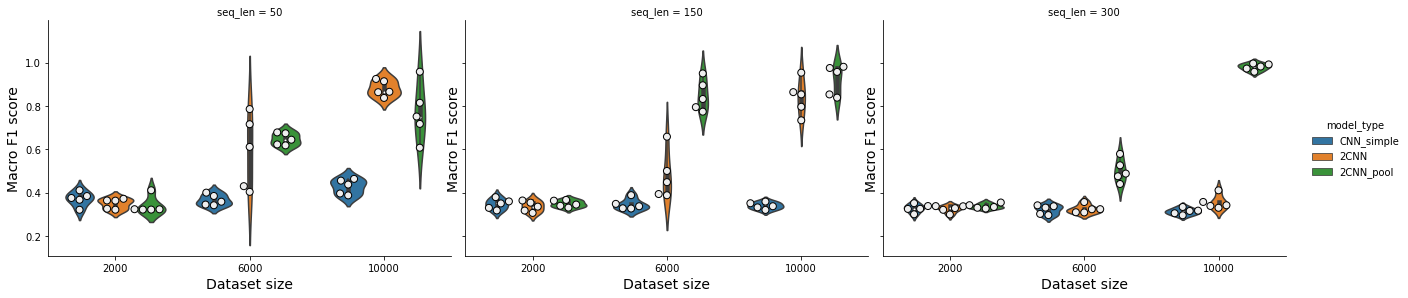

In [49]:
order = ['CNN_simple','2CNN','2CNN_pool']

g = sns.catplot(
    data=df_test, x='ds_size', y='mac_f1',
    col='seq_len', kind='violin',hue='model_type',
    hue_order=order,
    alpha=.3,height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='ds_size', y='mac_f1',
                hue='model_type',size=7, 
                hue_order=order,
                edgecolor='black',linewidth=1, dodge=True,palette=['#eeee'])

for ax in g.axes.flatten():
    ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
#plt.ylim(0,1)
plt.show()


### Quick check on model run time 

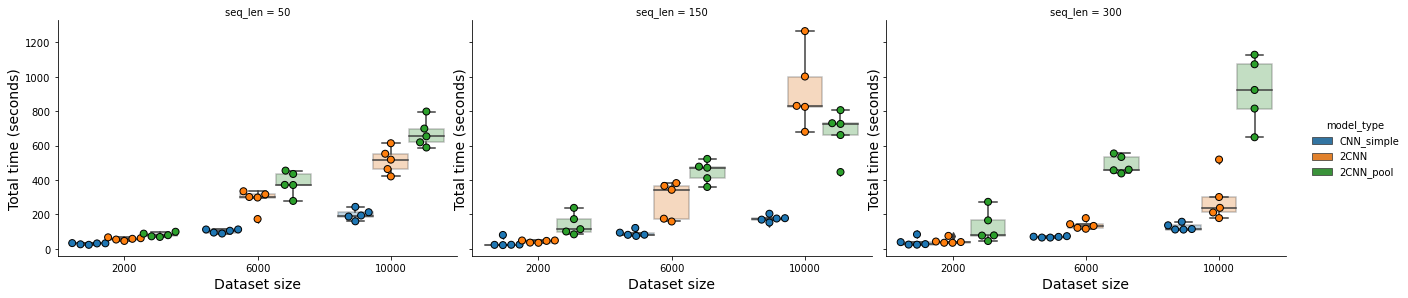

In [50]:
order = ['CNN_simple','2CNN','2CNN_pool']

g = sns.catplot(
    data=df_test, x='ds_size', y='total_time',
    col='seq_len', kind='box',hue='model_type',
    hue_order=order,
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='ds_size', y='total_time',
                hue='model_type',size=7, 
                hue_order=order,
                edgecolor='black',linewidth=1, dodge=True,palette='tab10')
for ax in g.axes.flatten():
    ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Total time (seconds)', fontsize=14)

plt.show()



# Summary of model performances across a 10bp ladder of sequence lengths

Varied:
* Model arch: Simple CNN, 2Conv CNN, 2Conv CNN with Pooling
* Number of training seqs: 2K, 6K, 10K
* Length of sequence: 30bp-150bp
* Ran 5 folds for each level

After running a number of combinations of each of these levers in `synth_classification_randomseqs.py`, and collecting the results in `out/synth_cls_10bp_ladder_result_df.tsv`, here are some summary plots.

In [7]:
from os import listdir

#dirname = '../hyak_scp_dump/out_synth_cls_10bp_ladder/'
#dirname = '../hyak_scp_dump/out_synth_cls_10bp_ladder_balanced/'
dirname = '../hyak_scp_dump/out_synth_cls_10bp_ladder_0.05b/'
#dirname = '../hyak_scp_dump/out_synth_cls_10bp_ladder_0.01b/'
filenames = listdir(dirname)
tsvs = [filename for filename in filenames if (filename.endswith('.tsv') and filename != 'all_pred_res.tsv')]

df5 = pd.DataFrame()
for f in tsvs:
    df_new = pd.read_csv(f'{dirname}/{f}',sep='\t')
    df5 = pd.concat([df5,df_new])

df5.to_csv("out_synth_cls/synth_cls_10bp_ladder_0.05b_result_df.tsv")
    
df5

,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,ds_size,seq_len,fold,best_val_score,epoch_stop,total_time
0,2CNN_pool_fold2_90bp_10000seqs,train,0.993510,0.999628,0.996549,8000,2CNN_pool,10000,90,2,0.011845,4458,1088.099841
1,2CNN_pool_fold2_90bp_10000seqs,test,0.996262,0.993148,0.994696,2000,2CNN_pool,10000,90,2,0.011845,4458,1088.099841
0,2CNN_pool_fold1_120bp_10000seqs,train,0.991933,0.999535,0.995700,8000,2CNN_pool,10000,120,1,0.026842,2567,691.861686
1,2CNN_pool_fold1_120bp_10000seqs,test,0.983596,0.992650,0.988052,2000,2CNN_pool,10000,120,1,0.026842,2567,691.861686
0,2CNN_pool_fold0_90bp_10000seqs,train,0.980295,0.998839,0.989418,8000,2CNN_pool,10000,90,0,0.032217,1949,538.800429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2CNN_pool_fold2_70bp_10000seqs,test,0.936113,0.989164,0.960244,2000,2CNN_pool,10000,70,2,0.031678,4020,990.646067
0,2CNN_pool_fold2_40bp_2000seqs,train,0.878524,0.990877,0.928549,1600,2CNN_pool,2000,40,2,0.101268,3149,186.606871
1,2CNN_pool_fold2_40bp_2000seqs,test,0.834414,0.970225,0.891956,400,2CNN_pool,2000,40,2,0.101268,3149,186.606871
0,2CNN_pool_fold3_130bp_10000seqs,train,1.000000,1.000000,1.000000,8000,2CNN_pool,10000,130,3,0.010682,1982,565.238792


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


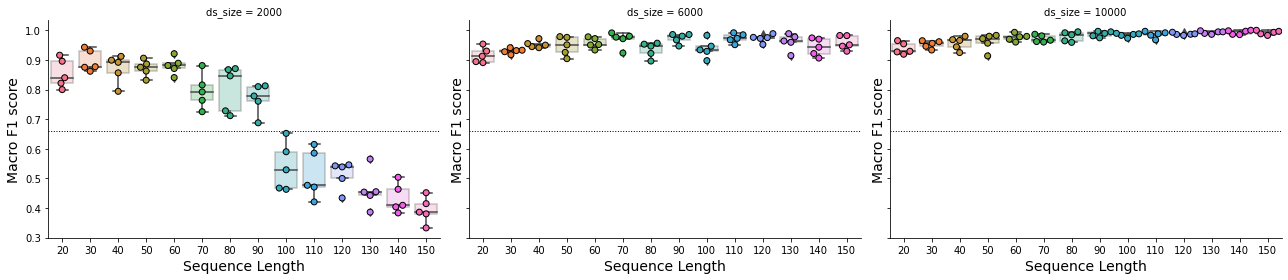

In [8]:
df5_test = df5[df5['split']=='test']

g = sns.catplot(
    data=df5_test, x='seq_len', y='mac_f1',
    col='ds_size', kind='box',
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=6, 
                edgecolor='black',linewidth=1, dodge=True,palette='husl')
g.map(plt.axhline, y=0.66, ls='dotted', c='black',lw=1)

for ax in g.axes.flatten():
    ax.set_xlabel('Sequence Length', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)

plt.tight_layout()
plt.savefig('img/10bp_ladder_b0.05.png', dpi=300)
plt.show()



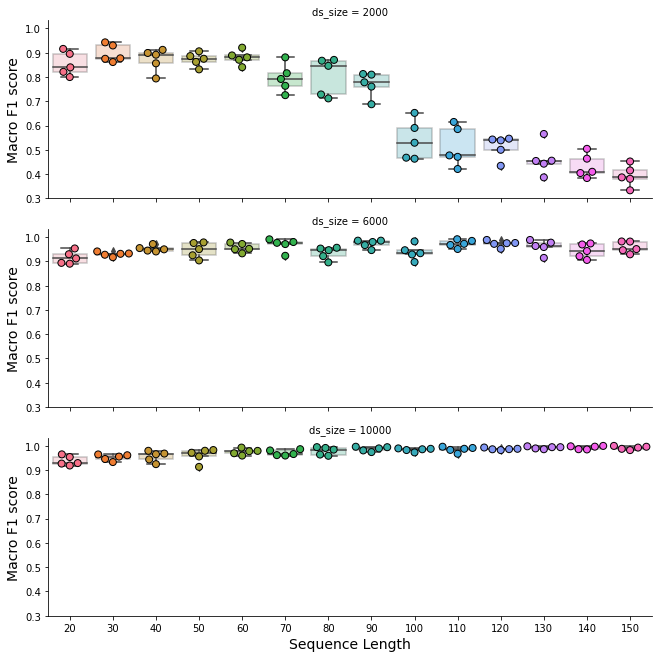

In [9]:

g = sns.catplot(
    data=df5_test, x='seq_len', y='mac_f1',
    row='ds_size', kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=6/2
)
g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=7, 
                edgecolor='black',linewidth=1, dodge=True,palette='husl')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Sequence Length",fontsize=14)

plt.show()



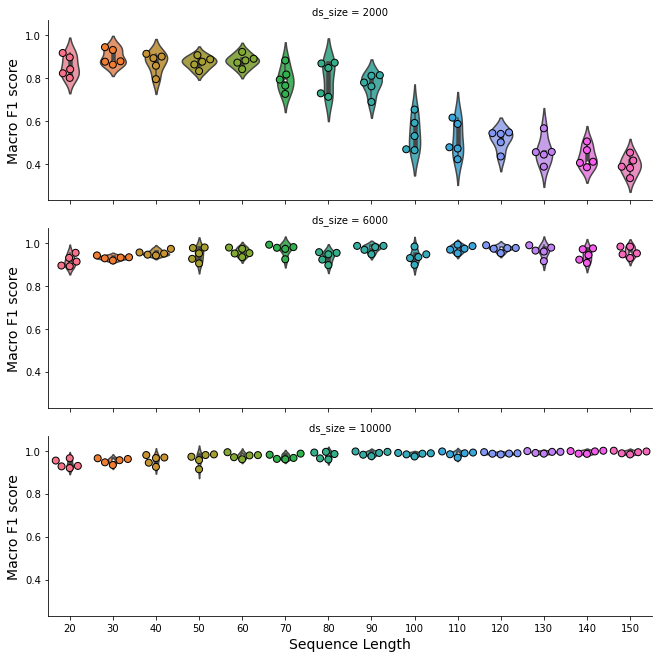

In [10]:

g = sns.catplot(
    data=df5_test, x='seq_len', y='mac_f1',
    row='ds_size', kind='violin',
    boxprops=dict(alpha=.3),height=3,aspect=6/2
)
g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=7, 
                edgecolor='black',linewidth=1, dodge=True,palette='husl')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Sequence Length",fontsize=14)

plt.show()



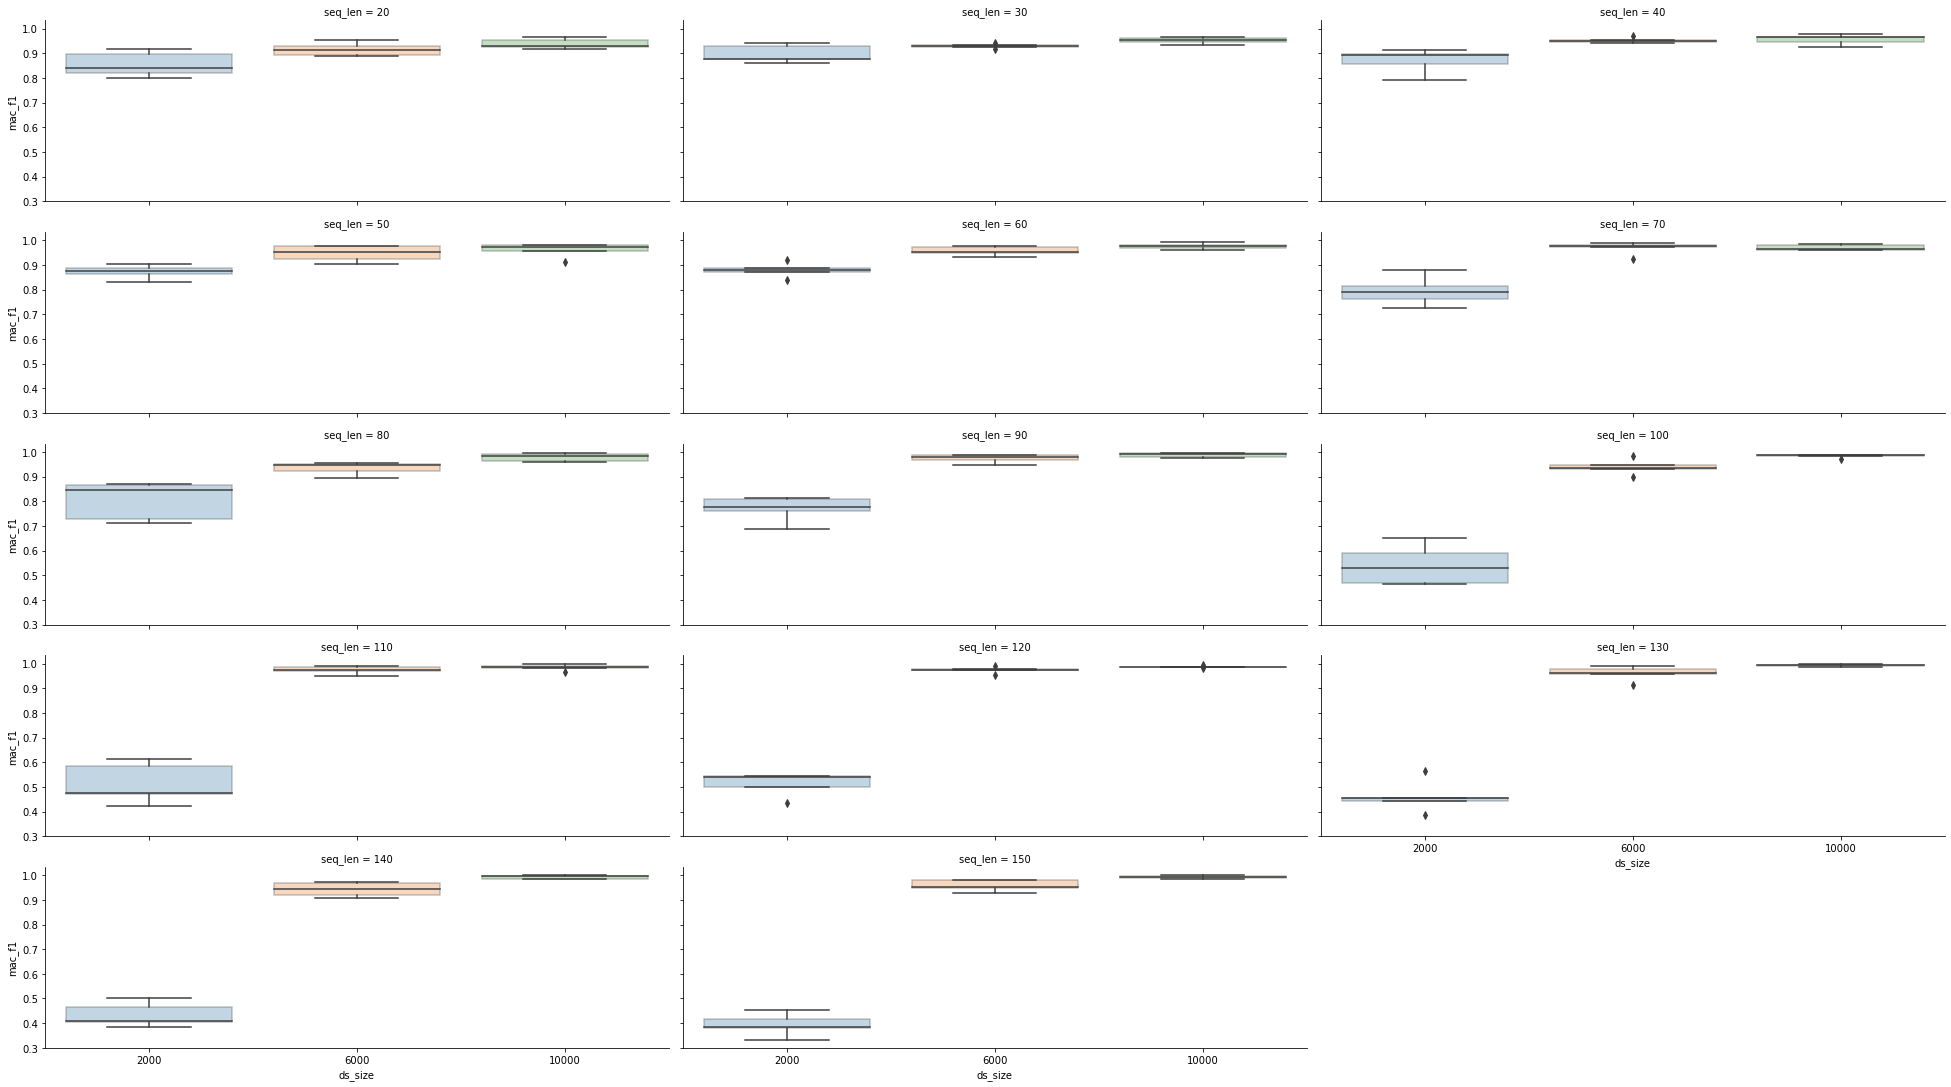

In [11]:
# g = sns.catplot(
#     data=df_test, x='ds_size', y='mac_f1',
#     row='seq_len', kind='box',color='ds_size',
#     boxprops=dict(alpha=.3),height=3,aspect=6/2
# )
# g.map_dataframe(sns.swarmplot, x='ds_size', y='mac_f1',
#                 size=7, 
#                 edgecolor='black',linewidth=1, dodge=True,palette='husl')

# for ax in g.axes.flatten():
#     #ax.set_xlabel('Dataset size', fontsize=14)
#     ax.set_ylabel('Macro F1 score', fontsize=14)
# plt.xlabel("Sequence Length",fontsize=14)

# plt.show()

sns.catplot(
    data=df5_test, x='ds_size', y='mac_f1',
    col='seq_len', kind='box',col_wrap=3,
    boxprops=dict(alpha=.3),height=3,aspect=6/2
)


## Check out balanced at 1% results

In [12]:
dirname = '../hyak_scp_dump/out_synth_cls_10bp_ladder_0.01b/'
filenames = listdir(dirname)
tsvs = [filename for filename in filenames if (filename.endswith('.tsv') and filename != 'all_pred_res.tsv')]

df1 = pd.DataFrame()
for f in tsvs:
    df_new = pd.read_csv(f'{dirname}/{f}',sep='\t')
    df1 = pd.concat([df1,df_new])

df1.to_csv("out_synth_cls/synth_cls_10bp_ladder_0.01b_result_df.tsv")
    
df1

,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,ds_size,seq_len,fold,best_val_score,epoch_stop,total_time
0,2CNN_pool_fold2_90bp_10000seqs,train,0.938123,0.998810,0.966958,4928,2CNN_pool,10000,90,2,0.114929,3190,486.957170
1,2CNN_pool_fold2_90bp_10000seqs,test,0.671568,0.718365,0.691564,1233,2CNN_pool,10000,90,2,0.114929,3190,486.957170
0,2CNN_pool_fold1_120bp_10000seqs,train,0.844784,0.995441,0.908757,4495,2CNN_pool,10000,120,1,0.233685,1242,215.330512
1,2CNN_pool_fold1_120bp_10000seqs,test,0.482894,0.457090,0.465844,1124,2CNN_pool,10000,120,1,0.233685,1242,215.330512
0,2CNN_pool_fold0_90bp_10000seqs,train,0.935290,0.998740,0.965304,4928,2CNN_pool,10000,90,0,0.116018,2269,364.440206
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2CNN_pool_fold2_70bp_10000seqs,test,0.687033,0.859813,0.755626,1503,2CNN_pool,10000,70,2,0.072667,2707,494.459997
0,2CNN_pool_fold2_40bp_2000seqs,train,0.793210,0.995930,0.874576,1600,2CNN_pool,2000,40,2,0.115473,893,66.692752
1,2CNN_pool_fold2_40bp_2000seqs,test,0.528139,0.598574,0.557380,400,2CNN_pool,2000,40,2,0.115473,893,66.692752
0,2CNN_pool_fold3_130bp_10000seqs,train,0.864872,0.996724,0.923133,4965,2CNN_pool,10000,130,3,0.234985,1562,278.536349


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


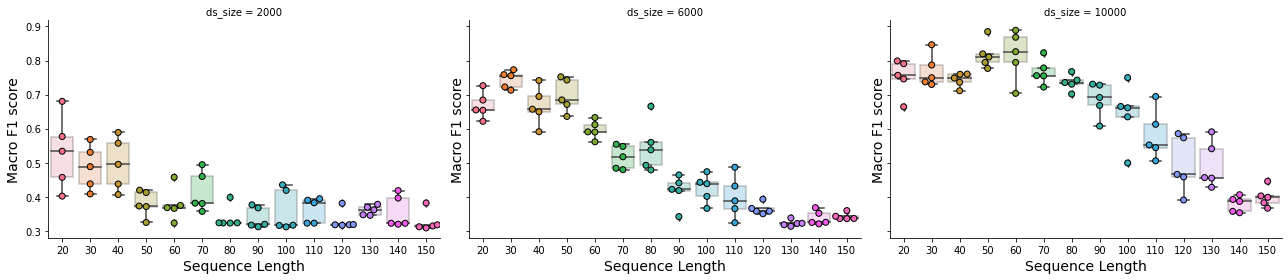

In [13]:
df1_test = df1[df1['split']=='test']

g = sns.catplot(
    data=df1_test, x='seq_len', y='mac_f1',
    col='ds_size', kind='box',
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=6, 
                edgecolor='black',linewidth=1, dodge=True,palette='husl')
for ax in g.axes.flatten():
    ax.set_xlabel('Sequence Length', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)

plt.tight_layout()
plt.savefig('img/10bp_ladder_b0.01.png', dpi=300)
plt.show()




/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


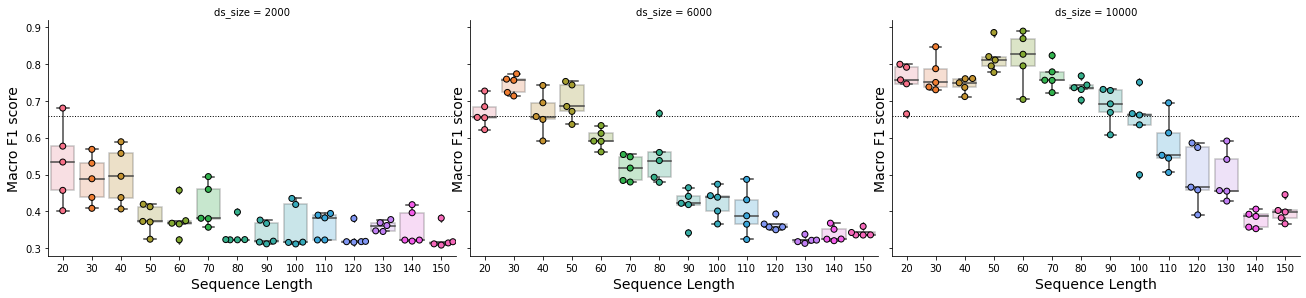

In [14]:
g = sns.catplot(
    data=df1_test, x='seq_len', y='mac_f1',
    col='ds_size', kind='box',
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=6, 
                edgecolor='black',linewidth=1, dodge=True,palette='husl')

#g.refline(x=0.66)
g.map(plt.axhline, y=0.66, ls='dotted', c='black',lw=1)

for ax in g.axes.flatten():
    ax.set_xlabel('Sequence Length', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)

# plt.tight_layout()
# plt.savefig('img/10bp_ladder_b0.01.png', dpi=300)
plt.show()


In [15]:
data = []
for seq_len in range(20,160,10):
    for motif_perc in [0.05,0.01]:
        for ds_size in [2000,6000,10000]:
            signal = 6/seq_len
            sig_perc = signal*motif_perc
            example_perc = sig_perc*ds_size
            print(f"{seq_len}|{motif_perc}|{ds_size}:\t{signal:.3f}\t{sig_perc:.5f}\t{example_perc:.5f}")
            row = [seq_len,motif_perc, ds_size,signal,sig_perc,example_perc]
            data.append(row)

sig_df = pd.DataFrame(data,columns=['seq_len','motif_perc','ds_size','signal','sig_perc','example_perc'])
    
    

20|0.05|2000:	0.300	0.01500	30.00000
20|0.05|6000:	0.300	0.01500	90.00000
20|0.05|10000:	0.300	0.01500	150.00000
20|0.01|2000:	0.300	0.00300	6.00000
20|0.01|6000:	0.300	0.00300	18.00000
20|0.01|10000:	0.300	0.00300	30.00000
30|0.05|2000:	0.200	0.01000	20.00000
30|0.05|6000:	0.200	0.01000	60.00000
30|0.05|10000:	0.200	0.01000	100.00000
30|0.01|2000:	0.200	0.00200	4.00000
30|0.01|6000:	0.200	0.00200	12.00000
30|0.01|10000:	0.200	0.00200	20.00000
40|0.05|2000:	0.150	0.00750	15.00000
40|0.05|6000:	0.150	0.00750	45.00000
40|0.05|10000:	0.150	0.00750	75.00000
40|0.01|2000:	0.150	0.00150	3.00000
40|0.01|6000:	0.150	0.00150	9.00000
40|0.01|10000:	0.150	0.00150	15.00000
50|0.05|2000:	0.120	0.00600	12.00000
50|0.05|6000:	0.120	0.00600	36.00000
50|0.05|10000:	0.120	0.00600	60.00000
50|0.01|2000:	0.120	0.00120	2.40000
50|0.01|6000:	0.120	0.00120	7.20000
50|0.01|10000:	0.120	0.00120	12.00000
60|0.05|2000:	0.100	0.00500	10.00000
60|0.05|6000:	0.100	0.00500	30.00000
60|0.05|10000:	0.100	0.00500	50.00

In [16]:
sig_df[sig_df['seq_len']==100]

,seq_len,motif_perc,ds_size,signal,sig_perc,example_perc
48,100,0.05,2000,0.06,0.0030,6.0
49,100,0.05,6000,0.06,0.0030,18.0
50,100,0.05,10000,0.06,0.0030,30.0
51,100,0.01,2000,0.06,0.0006,1.2
52,100,0.01,6000,0.06,0.0006,3.6
53,100,0.01,10000,0.06,0.0006,6.0


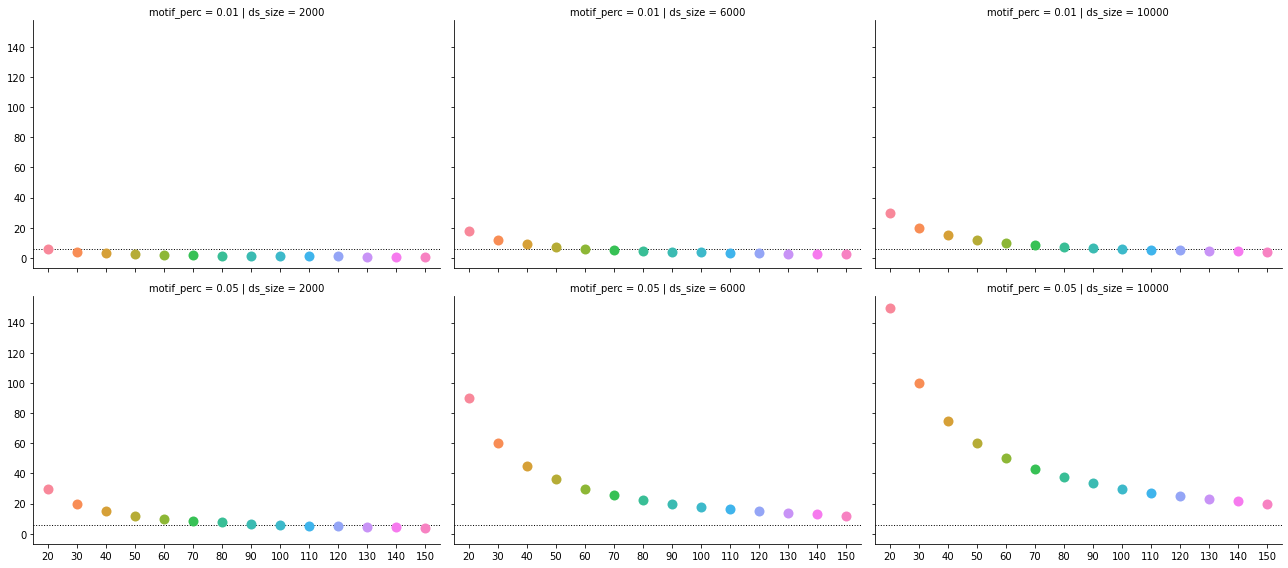

In [17]:
g = sns.catplot(
    data=sig_df, x='seq_len', y='example_perc',
    col='ds_size', kind='swarm',row='motif_perc',s=10,
    #boxprops=dict(alpha=.3),
    height=4,aspect=3/2
)


#g.refline(x=0.66)
g.map(plt.axhline, y=6, ls='dotted', c='black',lw=1)

# for ax in g.axes.flatten():
#     ax.set_xlabel('Sequence Length', fontsize=14)
#     ax.set_ylabel('Example Perc?', fontsize=14)

# plt.tight_layout()
# plt.savefig('img/10bp_ladder_b0.01.png', dpi=300)
#plt.yscale('log')
plt.show()

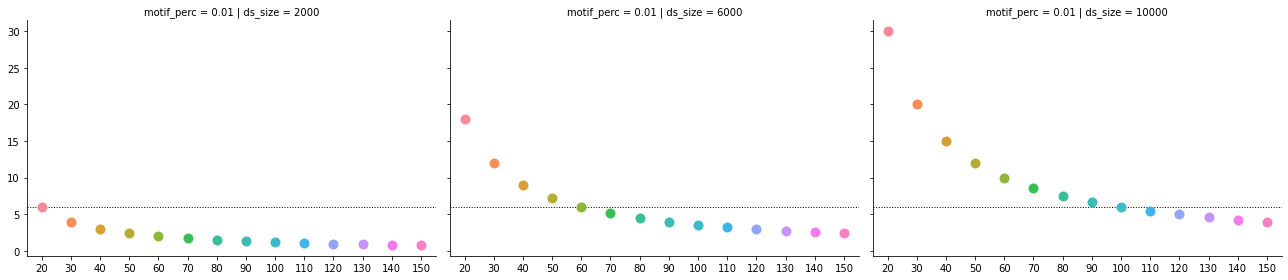

In [18]:
g = sns.catplot(
    data=sig_df[sig_df['motif_perc']==0.01], x='seq_len', y='example_perc',
    col='ds_size', kind='swarm',s=10,row='motif_perc',
    #boxprops=dict(alpha=.3),
    height=4,aspect=3/2
)


#g.refline(x=0.66)
g.map(plt.axhline, y=6, ls='dotted', c='black',lw=1)

# for ax in g.axes.flatten():
#     ax.set_xlabel('Sequence Length', fontsize=14)
#     ax.set_ylabel('Example Perc?', fontsize=14)

# plt.tight_layout()
# plt.savefig('img/10bp_ladder_b0.01.png', dpi=300)
#plt.yscale('log')
plt.show()

In [19]:
sig_df.sort_values('example_perc')[30:50]

,seq_len,motif_perc,ds_size,signal,sig_perc,example_perc
54,110,0.05,2000,0.054545,0.002727,5.454545
59,110,0.01,10000,0.054545,0.000545,5.454545
53,100,0.01,10000,0.060000,0.000600,6.000000
28,60,0.01,6000,0.100000,0.001000,6.000000
48,100,0.05,2000,0.060000,0.003000,6.000000
3,20,0.01,2000,0.300000,0.003000,6.000000
47,90,0.01,10000,0.066667,0.000667,6.666667
42,90,0.05,2000,0.066667,0.003333,6.666667
22,50,0.01,6000,0.120000,0.001200,7.200000
41,80,0.01,10000,0.075000,0.000750,7.500000


In [20]:
df1_test['motif_perc'] = 0.01
df5_test['motif_perc'] = 0.05

df_test = pd.concat([df1_test,df5_test])
df_test

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,ds_size,seq_len,fold,best_val_score,epoch_stop,total_time,motif_perc
1,2CNN_pool_fold2_90bp_10000seqs,test,0.671568,0.718365,0.691564,1233,2CNN_pool,10000,90,2,0.114929,3190,486.957170,0.01
1,2CNN_pool_fold1_120bp_10000seqs,test,0.482894,0.457090,0.465844,1124,2CNN_pool,10000,120,1,0.233685,1242,215.330512,0.01
1,2CNN_pool_fold0_90bp_10000seqs,test,0.628140,0.731557,0.668362,1233,2CNN_pool,10000,90,0,0.116018,2269,364.440206,0.01
1,2CNN_pool_fold2_130bp_10000seqs,test,0.581816,0.600892,0.590811,1242,2CNN_pool,10000,130,2,0.159748,1906,325.477430,0.01
1,2CNN_pool_fold0_40bp_10000seqs,test,0.610760,0.958138,0.711316,2000,2CNN_pool,10000,40,0,0.072572,3468,880.892000,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2CNN_pool_fold3_40bp_2000seqs,test,0.843762,0.971161,0.899057,400,2CNN_pool,2000,40,3,0.090778,2032,129.011086,0.05
1,2CNN_pool_fold0_30bp_2000seqs,test,0.841439,0.923779,0.877008,400,2CNN_pool,2000,30,0,0.125616,3243,215.945028,0.05
1,2CNN_pool_fold2_70bp_10000seqs,test,0.936113,0.989164,0.960244,2000,2CNN_pool,10000,70,2,0.031678,4020,990.646067,0.05
1,2CNN_pool_fold2_40bp_2000seqs,test,0.834414,0.970225,0.891956,400,2CNN_pool,2000,40,2,0.101268,3149,186.606871,0.05


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/e

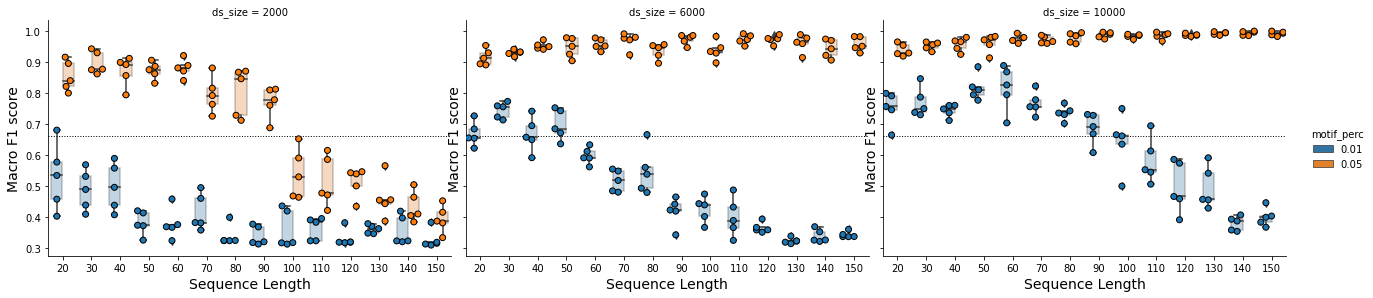

In [21]:
g = sns.catplot(
    data=df_test, x='seq_len', y='mac_f1',
    col='ds_size', kind='box',hue='motif_perc',
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=6,
                edgecolor='black',linewidth=1, dodge=True,
                hue='motif_perc',palette='tab10')#palette='husl')

#g.refline(x=0.66)
g.map(plt.axhline, y=0.66, ls='dotted', c='black',lw=1)

for ax in g.axes.flatten():
    ax.set_xlabel('Sequence Length', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)

# plt.tight_layout()
# plt.savefig('img/10bp_ladder_b0.01.png', dpi=300)
plt.show()

In [22]:
df_test

,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,ds_size,seq_len,fold,best_val_score,epoch_stop,total_time,motif_perc
1,2CNN_pool_fold2_90bp_10000seqs,test,0.671568,0.718365,0.691564,1233,2CNN_pool,10000,90,2,0.114929,3190,486.957170,0.01
1,2CNN_pool_fold1_120bp_10000seqs,test,0.482894,0.457090,0.465844,1124,2CNN_pool,10000,120,1,0.233685,1242,215.330512,0.01
1,2CNN_pool_fold0_90bp_10000seqs,test,0.628140,0.731557,0.668362,1233,2CNN_pool,10000,90,0,0.116018,2269,364.440206,0.01
1,2CNN_pool_fold2_130bp_10000seqs,test,0.581816,0.600892,0.590811,1242,2CNN_pool,10000,130,2,0.159748,1906,325.477430,0.01
1,2CNN_pool_fold0_40bp_10000seqs,test,0.610760,0.958138,0.711316,2000,2CNN_pool,10000,40,0,0.072572,3468,880.892000,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2CNN_pool_fold3_40bp_2000seqs,test,0.843762,0.971161,0.899057,400,2CNN_pool,2000,40,3,0.090778,2032,129.011086,0.05
1,2CNN_pool_fold0_30bp_2000seqs,test,0.841439,0.923779,0.877008,400,2CNN_pool,2000,30,0,0.125616,3243,215.945028,0.05
1,2CNN_pool_fold2_70bp_10000seqs,test,0.936113,0.989164,0.960244,2000,2CNN_pool,10000,70,2,0.031678,4020,990.646067,0.05
1,2CNN_pool_fold2_40bp_2000seqs,test,0.834414,0.970225,0.891956,400,2CNN_pool,2000,40,2,0.101268,3149,186.606871,0.05


In [23]:
merge_df = pd.merge(sig_df,df_test,how='left',on=['seq_len','ds_size','motif_perc'])
merge_df

,seq_len,motif_perc,ds_size,signal,sig_perc,example_perc,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,fold,best_val_score,epoch_stop,total_time
0,20,0.05,2000,0.30,0.0150,30.0,2CNN_pool_fold0_20bp_2000seqs,test,0.791809,0.907315,0.839894,400,2CNN_pool,0,0.128454,2109,157.450184
1,20,0.05,2000,0.30,0.0150,30.0,2CNN_pool_fold3_20bp_2000seqs,test,0.727299,0.928204,0.799817,400,2CNN_pool,3,0.202132,1919,127.422944
2,20,0.05,2000,0.30,0.0150,30.0,2CNN_pool_fold2_20bp_2000seqs,test,0.755565,0.921487,0.821313,400,2CNN_pool,2,0.186953,4282,250.183475
3,20,0.05,2000,0.30,0.0150,30.0,2CNN_pool_fold1_20bp_2000seqs,test,0.904616,0.931145,0.915869,400,2CNN_pool,1,0.065265,3960,232.221771
4,20,0.05,2000,0.30,0.0150,30.0,2CNN_pool_fold4_20bp_2000seqs,test,0.836538,0.985994,0.895516,400,2CNN_pool,4,0.111056,4205,246.966098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,150,0.01,10000,0.04,0.0004,4.0,2CNN_pool_fold1_150bp_10000seqs,test,0.392467,0.406602,0.398605,1289,2CNN_pool,1,0.295138,769,186.865866
416,150,0.01,10000,0.04,0.0004,4.0,2CNN_pool_fold2_150bp_10000seqs,test,0.389916,0.379014,0.382724,1289,2CNN_pool,2,0.302105,1604,309.401212
417,150,0.01,10000,0.04,0.0004,4.0,2CNN_pool_fold4_150bp_10000seqs,test,0.396723,0.410204,0.402665,1289,2CNN_pool,4,0.260451,643,169.660027
418,150,0.01,10000,0.04,0.0004,4.0,2CNN_pool_fold3_150bp_10000seqs,test,0.436751,0.458478,0.445627,1289,2CNN_pool,3,0.263722,1470,289.015167


In [24]:
filt_df = merge_df[merge_df['example_perc'].between(7,10)]
filt_df

,seq_len,motif_perc,ds_size,signal,sig_perc,example_perc,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,fold,best_val_score,epoch_stop,total_time
80,40,0.01,6000,0.150000,0.001500,9.000000,2CNN_pool_fold2_40bp_6000seqs,test,0.591377,0.780802,0.657157,1200,2CNN_pool,2,0.096863,2495,408.341367
81,40,0.01,6000,0.150000,0.001500,9.000000,2CNN_pool_fold4_40bp_6000seqs,test,0.565722,0.649174,0.591023,1200,2CNN_pool,4,0.120877,1693,297.562348
82,40,0.01,6000,0.150000,0.001500,9.000000,2CNN_pool_fold1_40bp_6000seqs,test,0.581025,0.776245,0.649455,1200,2CNN_pool,1,0.077758,3070,485.656075
83,40,0.01,6000,0.150000,0.001500,9.000000,2CNN_pool_fold3_40bp_6000seqs,test,0.669407,0.857574,0.741381,1200,2CNN_pool,3,0.073321,1640,290.150649
84,40,0.01,6000,0.150000,0.001500,9.000000,2CNN_pool_fold0_40bp_6000seqs,test,0.653516,0.749734,0.694541,1200,2CNN_pool,0,0.078477,3729,574.556619
110,50,0.01,6000,0.120000,0.001200,7.200000,2CNN_pool_fold2_50bp_6000seqs,test,0.749336,0.759700,0.752283,1200,2CNN_pool,2,0.072863,3356,491.833304
111,50,0.01,6000,0.120000,0.001200,7.200000,2CNN_pool_fold3_50bp_6000seqs,test,0.622280,0.784073,0.684463,1200,2CNN_pool,3,0.076435,1861,301.406531
112,50,0.01,6000,0.120000,0.001200,7.200000,2CNN_pool_fold4_50bp_6000seqs,test,0.634123,0.723810,0.671159,1200,2CNN_pool,4,0.072142,3469,505.633351
113,50,0.01,6000,0.120000,0.001200,7.200000,2CNN_pool_fold0_50bp_6000seqs,test,0.671964,0.859711,0.742794,1200,2CNN_pool,0,0.083279,3171,468.560949
114,50,0.01,6000,0.120000,0.001200,7.200000,2CNN_pool_fold1_50bp_6000seqs,test,0.608949,0.670391,0.635878,1200,2CNN_pool,1,0.079047,1380,240.713142


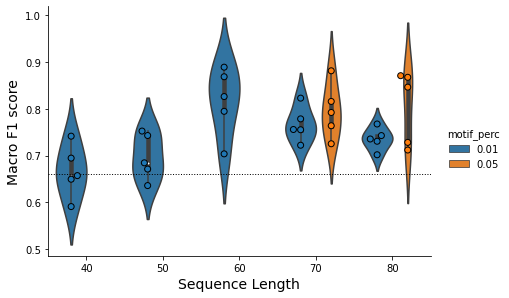

In [25]:
g = sns.catplot(
    data=filt_df, x='seq_len', y='mac_f1',
    kind='violin',hue='motif_perc',
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=6,
                edgecolor='black',linewidth=1, dodge=True,
                hue='motif_perc',palette='tab10')#palette='husl')

#g.refline(x=0.66)
g.map(plt.axhline, y=0.66, ls='dotted', c='black',lw=1)

for ax in g.axes.flatten():
    ax.set_xlabel('Sequence Length', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)

# plt.tight_layout()
# plt.savefig('img/10bp_ladder_b0.01.png', dpi=300)
plt.show()

In [26]:
merge_df.head(20)

,seq_len,motif_perc,ds_size,signal,sig_perc,example_perc,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,fold,best_val_score,epoch_stop,total_time
0,20,0.05,2000,0.3,0.015,30.0,2CNN_pool_fold0_20bp_2000seqs,test,0.791809,0.907315,0.839894,400,2CNN_pool,0,0.128454,2109,157.450184
1,20,0.05,2000,0.3,0.015,30.0,2CNN_pool_fold3_20bp_2000seqs,test,0.727299,0.928204,0.799817,400,2CNN_pool,3,0.202132,1919,127.422944
2,20,0.05,2000,0.3,0.015,30.0,2CNN_pool_fold2_20bp_2000seqs,test,0.755565,0.921487,0.821313,400,2CNN_pool,2,0.186953,4282,250.183475
3,20,0.05,2000,0.3,0.015,30.0,2CNN_pool_fold1_20bp_2000seqs,test,0.904616,0.931145,0.915869,400,2CNN_pool,1,0.065265,3960,232.221771
4,20,0.05,2000,0.3,0.015,30.0,2CNN_pool_fold4_20bp_2000seqs,test,0.836538,0.985994,0.895516,400,2CNN_pool,4,0.111056,4205,246.966098
5,20,0.05,6000,0.3,0.015,90.0,2CNN_pool_fold1_20bp_6000seqs,test,0.886781,0.981973,0.929840,1200,2CNN_pool,1,0.059108,3855,579.559717
6,20,0.05,6000,0.3,0.015,90.0,2CNN_pool_fold3_20bp_6000seqs,test,0.859976,0.979218,0.912509,1200,2CNN_pool,3,0.075015,4915,655.739046
7,20,0.05,6000,0.3,0.015,90.0,2CNN_pool_fold2_20bp_6000seqs,test,0.832729,0.981667,0.894139,1200,2CNN_pool,2,0.079107,4474,656.993536
8,20,0.05,6000,0.3,0.015,90.0,2CNN_pool_fold0_20bp_6000seqs,test,0.939316,0.970236,0.953569,1200,2CNN_pool,0,0.040147,4934,669.490776
9,20,0.05,6000,0.3,0.015,90.0,2CNN_pool_fold4_20bp_6000seqs,test,0.833255,0.970596,0.890791,1200,2CNN_pool,4,0.129806,4240,624.003982


In [27]:
# group merge df and average over folds
gdf = merge_df.groupby(['seq_len','motif_perc','ds_size'],as_index=False).mean()
gdf

,seq_len,motif_perc,ds_size,signal,sig_perc,example_perc,mac_precision,mac_recall,mac_f1,support,fold,best_val_score,epoch_stop,total_time
0,20,0.01,2000,0.30,0.0030,6.0,0.496580,0.607051,0.530038,400.0,2.0,0.170716,1545.6,95.131109
1,20,0.01,6000,0.30,0.0030,18.0,0.580254,0.872127,0.668192,1200.0,2.0,0.108236,2229.2,349.907681
2,20,0.01,10000,0.30,0.0030,30.0,0.656617,0.945297,0.751287,2000.0,2.0,0.062944,3717.2,859.651554
3,20,0.05,2000,0.30,0.0150,30.0,0.803165,0.934829,0.854482,400.0,2.0,0.138772,3295.0,202.848894
4,20,0.05,6000,0.30,0.0150,90.0,0.870411,0.976738,0.916169,1200.0,2.0,0.076637,4483.6,637.157411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,150,0.01,6000,0.04,0.0004,2.4,0.341530,0.347453,0.342266,773.0,2.0,0.347293,796.8,117.291393
80,150,0.01,10000,0.04,0.0004,4.0,0.395860,0.405751,0.399226,1289.0,2.0,0.281238,1111.0,237.092726
81,150,0.05,2000,0.04,0.0020,4.0,0.394556,0.399287,0.393284,400.0,2.0,0.622536,1854.8,119.021450
82,150,0.05,6000,0.04,0.0020,12.0,0.953841,0.964012,0.958233,1200.0,2.0,0.053464,3233.4,530.092575


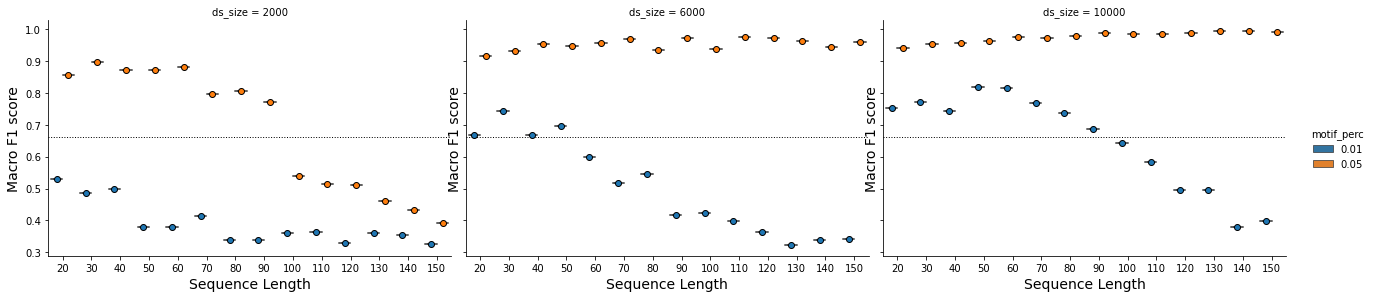

In [28]:
g = sns.catplot(
    data=gdf, x='seq_len', y='mac_f1',
    col='ds_size', kind='box',hue='motif_perc',
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=6,
                edgecolor='black',linewidth=1, dodge=True,
                hue='motif_perc',palette='tab10')#palette='husl')

#g.refline(x=0.66)
g.map(plt.axhline, y=0.66, ls='dotted', c='black',lw=1)

for ax in g.axes.flatten():
    ax.set_xlabel('Sequence Length', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)

# plt.tight_layout()
# plt.savefig('img/10bp_ladder_b0.01.png', dpi=300)
plt.show()

In [29]:
folds = alt.Chart(merge_df).mark_point(size=60,opacity=0.5).encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
    
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

means = alt.Chart(gdf).mark_point(size=80,filled=True,stroke="black").encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
    
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

folds+means

alt.LayerChart(...)

In [30]:
alt.hconcat(means,folds)

alt.HConcatChart(...)

In [31]:
folds = alt.Chart(merge_df).mark_point(size=60,opacity=0.5).encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    row='ds_size:N',
    shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
    
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=100
)

means = alt.Chart(gdf).mark_point(size=80,filled=True,stroke="black").encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    row='ds_size:N',
    shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
    
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=100
)

alt.hconcat(means,folds)

alt.HConcatChart(...)

In [34]:
# folds = alt.Chart(merge_df).mark_point(size=60,opacity=0.5).encode(
#     x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
#     y=alt.Y('mac_f1:Q'),
#     shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
#     color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
#     column='motif_perc:N',
#     tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
# ).interactive().properties(
#     width=300,
#     height=300
# )

means = alt.Chart(gdf).mark_point(size=80,filled=True,stroke="black").encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
    column='motif_perc:N',
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

#folds+means
means

alt.Chart(...)

In [38]:
means = alt.Chart(gdf).mark_point(size=80,filled=True,stroke="black").encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_perc:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)
means

alt.Chart(...)

In [52]:
sds_df = merge_df[merge_df['ds_size']==2000]
mds_df = merge_df[merge_df['ds_size']==6000]
lds_df = merge_df[merge_df['ds_size']==10000]

sdsm_df = gdf[gdf['ds_size']==2000]
mdsm_df = gdf[gdf['ds_size']==6000]
ldsm_df = gdf[gdf['ds_size']==10000]

In [40]:
lds_df

,seq_len,motif_perc,ds_size,signal,sig_perc,example_perc,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,fold,best_val_score,epoch_stop,total_time
10,20,0.05,10000,0.30,0.0150,150.0,2CNN_pool_fold3_20bp_10000seqs,test,0.881115,0.988500,0.929183,2000,2CNN_pool,3,0.054790,3891,952.751474
11,20,0.05,10000,0.30,0.0150,150.0,2CNN_pool_fold2_20bp_10000seqs,test,0.929069,0.985174,0.954102,2000,2CNN_pool,2,0.042166,4231,1016.157101
12,20,0.05,10000,0.30,0.0150,150.0,2CNN_pool_fold4_20bp_10000seqs,test,0.872417,0.977886,0.919144,2000,2CNN_pool,4,0.062988,3157,793.975244
13,20,0.05,10000,0.30,0.0150,150.0,2CNN_pool_fold0_20bp_10000seqs,test,0.876675,0.991277,0.927038,2000,2CNN_pool,0,0.063325,1858,511.591306
14,20,0.05,10000,0.30,0.0150,150.0,2CNN_pool_fold1_20bp_10000seqs,test,0.942504,0.990063,0.965090,2000,2CNN_pool,1,0.025192,4691,1076.240546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,150,0.01,10000,0.04,0.0004,4.0,2CNN_pool_fold1_150bp_10000seqs,test,0.392467,0.406602,0.398605,1289,2CNN_pool,1,0.295138,769,186.865866
416,150,0.01,10000,0.04,0.0004,4.0,2CNN_pool_fold2_150bp_10000seqs,test,0.389916,0.379014,0.382724,1289,2CNN_pool,2,0.302105,1604,309.401212
417,150,0.01,10000,0.04,0.0004,4.0,2CNN_pool_fold4_150bp_10000seqs,test,0.396723,0.410204,0.402665,1289,2CNN_pool,4,0.260451,643,169.660027
418,150,0.01,10000,0.04,0.0004,4.0,2CNN_pool_fold3_150bp_10000seqs,test,0.436751,0.458478,0.445627,1289,2CNN_pool,3,0.263722,1470,289.015167


In [68]:
sds = alt.Chart(sds_df).mark_point(size=60,opacity=0.5).encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_perc:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='oranges',reverse=True)),
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

mds = alt.Chart(mds_df).mark_point(size=60,opacity=0.5).encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_perc:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='greens',reverse=True)),
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

lds = alt.Chart(lds_df).mark_point(size=60,opacity=0.5).encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_perc:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='purples',reverse=True)),
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

test = mds + sds + lds
test.resolve_scale(color='independent').configure_axis(grid=False)

alt.LayerChart(...)

In [75]:
op = 0.9
sds = alt.Chart(sdsm_df).mark_point(size=80,filled=True,opacity=op).encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_perc:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='oranges',reverse=True)),
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

mds = alt.Chart(mdsm_df).mark_point(size=80,filled=True,opacity=op).encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_perc:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='greens',reverse=True)),
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

lds = alt.Chart(ldsm_df).mark_point(size=80,filled=True,opacity=op).encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_perc:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='purples',reverse=True)),
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

testm = mds + sds + lds
testm = testm.resolve_scale(color='independent')
testm.configure_axis(grid=False)

alt.LayerChart(...)

In [70]:
comb = test+testm
comb.resolve_scale(color='independent').configure_axis(grid=False)

alt.LayerChart(...)

In [78]:
op = 0.9
filled=False
s5ds = alt.Chart(sds_df[sds_df['motif_perc']==0.05]).mark_point(size=80,filled=filled,opacity=op).encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_perc:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='oranges',reverse=True)),
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

l1ds = alt.Chart(lds_df[lds_df['motif_perc']==0.01]).mark_point(size=80,filled=filled,opacity=op).encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_perc:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='purples',reverse=True)),
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

testx = s5ds + l1ds
testx = testx.resolve_scale(color='independent')
testx.configure_axis(grid=False)

alt.LayerChart(...)

In [77]:
op = 0.9
s5ds = alt.Chart(sdsm_df[sdsm_df['motif_perc']==0.05]).mark_point(size=80,filled=True,opacity=op).encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_perc:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='oranges',reverse=True)),
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

l1ds = alt.Chart(ldsm_df[ldsm_df['motif_perc']==0.01]).mark_point(size=80,filled=True,opacity=op).encode(
    x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_perc:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='purples',reverse=True)),
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
).interactive().properties(
    width=300,
    height=300
)

testx = s5ds + l1ds
testx = testx.resolve_scale(color='independent')
testx.configure_axis(grid=False)

alt.LayerChart(...)